#### Pre-defs & Pre-loads

In [ ]:
# ! pip3 install torchmetrics
! pip install moabb mne
# ! pip3 install pyEDFlib
# ! pip3 uninstall -y numpy scipy
# ! pip3 install --no-cache-dir numpy==1.26.4 scipy==1.11.4
# time.sleep(0.25)
# clear_output()

In [ ]:
from IPython import display
from IPython.display import clear_output
import time
import logging
import warnings
import contextlib
import io

logging.basicConfig(level=logging.ERROR)
warnings.filterwarnings("ignore")

import os
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
from tqdm import tqdm
import gc
import joblib
import random
import math

import mne

import numpy as np
import pandas as pd
import scipy.io

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming
import librosa

import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcdefaults()  # reset to Matplotlib defaults
import seaborn as sns
from PIL import Image
# import cv2
import shutil

In [ ]:
import yaml

with open("config.yaml") as f:
  config = yaml.safe_load(f)

#### Load Dataset Configs

In [ ]:
# @title Functions

def get_subject_imagery_epochs(subject):
  left_imagery_epochs = []
  right_imagery_epochs = []

  raw = mne.io.read_raw_edf(os.path.join('edffile', subject, 'eeg', f'{subject}_task-motor-imagery_eeg.edf'))
  eeg_data = raw.get_data()

  for annotn in annotations:
    s_idx = annotn[0]
    e_idx = annotn[0] + annotn[1]

    epoch = eeg_data[:, s_idx:e_idx]
    if annotn[2]==1:
      left_imagery_epochs.append(epoch)
    elif annotn[2]==2:
      right_imagery_epochs.append(epoch)

  left_imagery_epochs = np.array(left_imagery_epochs)
  right_imagery_epochs = np.array(right_imagery_epochs)

  return left_imagery_epochs, right_imagery_epochs

def get_all_subjects_imagery_epochs(subjects):
  left_imagery_epochs = None
  right_imagery_epochs = None

  for subject in subjects:
    left_imagery, right_imagery = get_subject_imagery_epochs(subject)

    if left_imagery_epochs is None:
      left_imagery_epochs = left_imagery
    else:
      left_imagery_epochs = np.concatenate((left_imagery_epochs, left_imagery), axis=0)

    if right_imagery_epochs is None:
      right_imagery_epochs = right_imagery
    else:
      right_imagery_epochs = np.concatenate((right_imagery_epochs, right_imagery), axis=0)

    clear_output()

  return left_imagery_epochs, right_imagery_epochs

def preprocess_epochs(subject_epochs, l_freq=0.5, h_freq=40, preprocessing_pipeline=None):
  subject_epochs = mne.filter.filter_data(subject_epochs, sfreq=fs, l_freq=l_freeq, h_freq=h_freq)

  if preprocessing_pipeline is None:
    return subject_epochs
  else:
    pass

In [ ]:
dataset_dir = os.path.join(config['DATASET_DIR'], 'strokeMI_Liu2024', 'edffile.zip')
! unzip $dataset_dir
clear_output()
print("EDFs Unzipped")

EDFs Unzipped


In [ ]:
import json

with open(os.path.join(config['DATASET_DIR'], 'strokeMI_Liu2024', 'task-motor-imagery_eeg.json')) as f:
  eeg_info = json.load(f)

fs = eeg_info['SamplingFrequency']
f_DC = eeg_info['PowerLineFrequency']
REF = eeg_info['EEGReference']
GND = eeg_info['EEGGround']

In [ ]:
annotations = pd.read_csv(os.path.join(config['DATASET_DIR'], 'strokeMI_Liu2024', 'task-motor-imagery_events.tsv'), sep='\t')
annotations = annotations[annotations['value']==2]
annotations = annotations[['onset', 'duration', 'trial_type']].values

for idx in range(annotations.shape[0]):
  annotations[idx, 0:2] = (annotations[idx, 0:2] / 1000) * fs

In [ ]:
channels = pd.read_csv(os.path.join(config['DATASET_DIR'], 'strokeMI_Liu2024', 'task-motor-imagery_channels.tsv'), sep='\t')
channels_idx = chs_idx = list(map(int, channels.index.values))
channel_types = ch_tps = list(channels['type'].values)
channels = chs = list(channels['name'].values)
channels_map = chs_map = dict(zip(channels, channels_idx))

# STFT-CNN Classification

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# @title Training Helpers

class LRScheduler:

    def __init__(self, lr, patience, factor=0.7, margin=0.1, n_evals=100):
        self.lr0 = lr
        self.lr = lr
        self.patience = patience
        self.factor = factor
        self.steps =1
        self.counts = 0
        self.best_metric = float("inf")
        self.margin = margin
        self.n_evals = n_evals

    def exponential_lr(self, metric):
        if metric - self.best_metric > self.margin:
            self.counts += 1
            if self.counts >= self.patience:
                self.best_metric = metric
                self.counts = 0
                self.steps += 1
                self.lr = self.lr0*math.exp(-1*self.factor*self.steps)
                if self.lr < 3E-8:
                    self.lr = 3E-8
        elif metric + self.margin < self.best_metric:
            self.best_metric = metric
            self.counts = 0
        return self.lr


class EarlyStopping:
  def __init__(self, patience=5, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.best_val_loss = float("inf")
    self.counter = 0

  def check(self, val_loss):
    if val_loss < self.best_val_loss - self.min_delta:
      self.best_val_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1

    return self.counter >= self.patience

class CheckpointModel:
  def __init__(self, margin=0.0):
    self.margin = margin
    self.best_metric = float("inf")
    self.best_state = None

  def checkpoint(self, metric, model, message="Checkpoint Model @ Loss"):
    if metric + self.margin < self.best_metric:
      self.best_metric = metric
      self.best_state = model.state_dict()
      if message is not None:
        print(message)

def init_weights_kaiming_normal(self, seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  for m in self.modules():
    if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight, 1)
      nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
      nn.init.normal_(m.weight, 0, 0.01)
      nn.init.constant_(m.bias, 0)

def accuracy_score(logits, classes):
    probs = F.softmax(logits, dim=-1)
    pred = torch.argmax(probs, dim=-1)
    acc = (pred == classes)
    acc  = acc.sum()/len(acc)
    return acc

def binary_acc(y_pred, y_test):
    # y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred_tag = torch.where(y_pred >= 0.5, 1, 0)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
# @title Dataset Class & Augmentation Class

from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from einops import rearrange

class Compose:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, x):
    for t in self.transforms:
      x = t(x)
    return x

class Masking:
  '''
  Augmentation for EEG spectrograms: masking channels, time, and frequency.
  '''
  def __init__(self, channel_dropout_prob=0.1, time_mask_width=4, freq_mask_width=4):
    self.channel_dropout_prob = channel_dropout_prob
    self.time_mask_width = time_mask_width
    self.freq_mask_width = freq_mask_width

  def __call__(self, x):
    C, F, T = x.size()

    # # --- Channel Dropout ---
    # if random.random() < self.channel_dropout_prob:
    #   num_drop = max(1, int(C * self.channel_dropout_prob))
    #   drop_indices = random.sample(range(C), num_drop)
    #   x[:, :, drop_indices] = 0

    # --- Time Masking ---
    if T > self.time_mask_width:
      t0 = random.randint(0, T - self.time_mask_width)
      x[:, :, t0:t0+self.time_mask_width] = 0

    # --- Frequency Masking ---
    if F > self.freq_mask_width:
      f0 = random.randint(0, F - self.freq_mask_width)
      x[ :, f0:f0+self.freq_mask_width, :] = 0

    return x

class TimeShifting:
    '''
    Augmentation for EEG spectrograms: shifts the time dimension by a random amount.
    '''
    def __init__(self, max_shift_ratio=0.2):
        """
        Parameters:
        max_shift_ratio (float): Maximum amount to shift as a ratio of the total time dimension
                                 (e.g., 0.2 means shift up to 20% of the time axis)
        """
        self.max_shift_ratio = max_shift_ratio

    def __call__(self, x):
        C, F, T = x.size()

        # Calculate the maximum shift in time steps
        max_shift = int(T * self.max_shift_ratio)
        if max_shift < 1:
            return x

        # Generate a random shift amount (-max_shift to max_shift)
        shift_amount = random.randint(-max_shift, max_shift)

        # Create a shifted version using roll
        shifted_x = torch.roll(x, shifts=shift_amount, dims=1)

        # If shifting right, zero out the beginning
        if shift_amount > 0:
            shifted_x[:, :, :shift_amount] = 0
        # If shifting left, zero out the end
        elif shift_amount < 0:
            shifted_x[:, :, shift_amount:] = 0

        return shifted_x


class NoiseAugmentation:
    '''
    Augmentation for EEG spectrograms: adds different types of noise.
    '''
    def __init__(self, noise_types=['gaussian', 'saltpepper'],
                 gaussian_std_range=(0.01, 0.05),
                 saltpepper_prob_range=(0.01, 0.05),
                 saltpepper_intensity_range=(0.2, 1.0)):
        """
        Parameters:
        noise_types (list): Types of noise to potentially apply ('gaussian', 'saltpepper')
        gaussian_std_range (tuple): Range for standard deviation for Gaussian noise
        saltpepper_prob_range (tuple): Range for probability of salt and pepper noise
        saltpepper_intensity_range (tuple): Range for intensity of salt and pepper noise
        """
        self.noise_types = noise_types
        self.gaussian_std_range = gaussian_std_range
        self.saltpepper_prob_range = saltpepper_prob_range
        self.saltpepper_intensity_range = saltpepper_intensity_range

    def __call__(self, x):
        # Choose one noise type randomly
        noise_type = random.choice(self.noise_types)

        if noise_type == 'gaussian':
            return self._add_gaussian_noise(x)
        elif noise_type == 'saltpepper':
            return self._add_saltpepper_noise(x)
        return x

    def _add_gaussian_noise(self, x):
        std = random.uniform(*self.gaussian_std_range)
        noise = torch.randn_like(x) * std
        return torch.clamp(x + noise, 0.0, 1.0)  # Assuming data is normalized to [0, 1]

    def _add_saltpepper_noise(self, x):
        prob = random.uniform(*self.saltpepper_prob_range)
        intensity = random.uniform(*self.saltpepper_intensity_range)

        # Create a mask for the noise positions
        mask = torch.rand_like(x) < prob

        # Create salt (high value) and pepper (low value) masks
        salt = mask & (torch.rand_like(x) < 0.5)
        pepper = mask & ~salt

        # Apply salt and pepper noise
        result = x.clone()
        result[salt] = torch.clamp(result[salt] + intensity, 0.0, 1.0)
        result[pepper] = torch.clamp(result[pepper] - intensity, 0.0, 1.0)

        return result

# from fancyPCA import *
# class FancyPCA:

#   def __init__(self, alpha):
#     self.alpha = alpha

#   def __call__(self, x):
#     res = batch_fpca(x, self.alpha)
#     return res

class elbowMIDataset(Dataset):

  def __init__(self, X, y=None, transform=None, augment_prob=0.3):
    super(elbowMIDataset, self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    if y is not None:
      self.y = torch.tensor(y, dtype=torch.long)
    else:
      self.y = None
    self.transform = transform
    self.transform_p = augment_prob

  def __len__(self):
    if self.y is not None:
      assert len(self.X) == len(self.y)
    return self.X.size(0)

  def __getitem__(self, idx):
    x = self.X[idx,::]
    if (self.transform is not None) and (random.random()<self.transform_p):
      x = self.transform(x)
    if self.y is not None:
      return x, self.y[idx]
    return x

from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

def stratified_split(X, y, test_size=0.2):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
  train_idx, test_idx = next(sss.split(X, y))

  return (X[train_idx, ::], y[train_idx]), (X[test_idx, ::], y[test_idx])

def make_spectrogram_channels_image(X):
  B, C, _, _ = X.shape
  X_img = np.empty((B, C, 224, 224))

  for ch_idx in range(X.shape[1]):
    for s_idx in range(X.shape[0]):

      arr = X[s_idx, ch_idx, ::]
      arr = cv2.normalize(arr, None, 0, 255, cv2.NORM_MINMAX)
      arr = arr.astype(np.uint8)
      arr = cv2.resize(arr, (224, 224), interpolation=cv2.INTER_LINEAR)
      arr = arr.reshape((1, 224, 224))
      X_img[s_idx, ch_idx, ::] = arr

  return X_img

from fancyPCA import *
def FancyPCA_Augmentation(X, y, alpha, ratio):
  N = int(ratio*len(X))
  idx = np.random.choice(len(X), N, replace=False)
  x = X[idx, ::]
  y = y[idx]

  x = batch_fpca(x, alpha)
  return x, y

#### Models

In [ ]:
# @title Transformer Helper Classes

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        # Linear transformations and reshape
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        # Apply attention to values
        context = torch.matmul(attention, V)

        # Reshape and apply output projection
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.w_o(context)

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output = self.self_attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class EncoderClassifier(nn.Module):
    def __init__(self, d_model, n_tokens, num_heads, d_ff, n_layers, dropout=0.1):
        super().__init__()

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embedding = nn.Parameter(torch.zeros(1, n_tokens+1, d_model))

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        B, T, E = x.size()

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)

        for layer in self.layers:
          x = layer(x, mask=None)

        x = self.norm(x)

        return x

In [ ]:
# @title CNNs

import torch.nn.functional as F

class BACKBONE_CNN(nn.Module):
  def __init__(self):
    super(BACKBONE_CNN, self).__init__()

    self.in_btn = nn.BatchNorm2d(3)
    self.conv11 = nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.relu11 = nn.LeakyReLU(inplace=True)
    self.btn11 = nn.BatchNorm2d(3)
    self.avgpool11 = nn.AvgPool2d((2, 2))

    self.conv21 = nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.relu21 = nn.LeakyReLU(inplace=True)
    self.btn21 = nn.BatchNorm2d(3)
    self.avgpool21 = nn.AvgPool2d((2, 2))

    self.conv31 = nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.relu31 = nn.LeakyReLU(inplace=True)
    self.btn31 = nn.BatchNorm2d(3)
    self.avgpool31 = nn.AvgPool2d((2, 2))

    # self.fc = nn.Linear(3*16*16, 2)

  def forward(self, x):
    x = self.in_btn(x)
    x = self.conv11(x)
    x = self.btn11(x)
    x = self.relu11(x)
    x = self.avgpool11(x)

    x = self.conv21(x)
    x = self.btn21(x)
    x = self.relu21(x)
    x = self.avgpool21(x)

    x = self.conv31(x)
    x = self.btn31(x)
    x = self.relu31(x)
    x = self.avgpool31(x)

    # x = rearrange(x, 'b c h w -> b (c h w)')
    # logits = self.fc(x)
    # return logits

    return x

class SPEC_CNN(nn.Module):
  def __init__(self):
    super(SPEC_CNN, self).__init__()

    self.backbone = BACKBONE_CNN()

    self.conv12 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.relu12 = nn.LeakyReLU(inplace=True)
    self.btn12 = nn.BatchNorm2d(1)
    self.avgpool12 = nn.AdaptiveAvgPool2d((32, 32))

    self.conv13 = nn.Conv2d(3, 1, kernel_size=(1, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.relu13 = nn.LeakyReLU(inplace=True)
    self.btn13 = nn.BatchNorm2d(1)
    self.avgpool13 = nn.AdaptiveAvgPool2d((32, 32))

    self.fc = nn.Linear(2*32*32, 2)

  def forward(self, x):
    x = self.backbone(x)

    x12 = self.conv12(x)
    x12 = self.btn12(x12)
    x12 = self.relu12(x12)
    x12 = self.avgpool12(x12)

    x13 = self.conv13(x)
    x13 = self.btn13(x13)
    x13 = self.relu13(x13)
    x13 = self.avgpool13(x13)

    x_out = torch.cat((x12, x13), dim=1)
    x_out = rearrange(x_out, 'b c h w -> b (c h w)')
    logits = self.fc(x_out)
    return logits

class SPEC_CNN_T1(nn.Module):
  def __init__(self, d_in=60, d_model=60, n_tokens=28, num_heads=1, d_ff=128, n_layers=1, dropout=0.1):
    super(SPEC_CNN_T1, self).__init__()

    self.d_in = d_in
    self.E = d_model

    self.backbone = BACKBONE_CNN()
    self.embedding = nn.Linear(d_in, d_model)
    self.embedding_relu = nn.ReLU()
    self.enc1 = EncoderClassifier(d_model=d_model, n_tokens=n_tokens, num_heads=num_heads, d_ff=d_ff, n_layers=n_layers, dropout=dropout)
    self.fc = nn.Linear(d_model, 2)

  def forward(self, x):
    x = self.backbone(x)

    x = rearrange(x, 'b c h w -> b w (c h)')
    B, T, e = x.size()
    assert e == self.d_in

    x = self.embedding_relu(self.embedding(x))
    # print(x.size())
    x = self.enc1(x)
    cls_token = x[:, 0, :]
    logits = self.fc(cls_token)
    return logits

  def get_embedding(self, x):
    x = self.backbone(x)

    x = rearrange(x, 'b c h w -> b w (c h)')
    B, T, e = x.size()
    assert e == self.d_in

    x = self.embedding_relu(self.embedding(x))
    # print(x.size())
    x = self.enc1(x)
    return x


In [ ]:
# @title Model Forward-Eval

def run(model, x, y=None, transforms=None, LBL_SMOOTH=0.0):
  if transforms is not None:
    x = transforms(x)

  logits = model(x)
  if y is not None:
    # y = y.unsqueeze(1)
    # y = y.to(torch.float)
    loss = F.cross_entropy(logits, y, label_smoothing=LBL_SMOOTH)
    acc = accuracy_score(logits, y)
    return logits, loss, acc
  return logits

## Left vs Right Motor-Imagery Classification
-  Liu2024

In [ ]:
# @title Functions & Classes

from sklearn.base import BaseEstimator, TransformerMixin
from mne.filter import filter_data

class TWFB(BaseEstimator, TransformerMixin):
  def __init__(self, windows, bands, sfreq):
    self.windows = windows
    self.bands = bands
    self.sfreq = sfreq

  def transform(self, X):
    feats = []
    for (t0, t1) in self.windows:
        for (f_low, f_high) in self.bands:
            Xf = filter_data(X, self.sfreq, f_low, f_high, picks=None)
            feats.append(Xf[..., int(t0*self.sfreq):int(t1*self.sfreq)])
    return np.stack(feats, axis=1)  # (trials, windows*bands, channels, time)

  def fit(self, X, y=None):
      return self


In [ ]:
# @title Preprocessing Configs

TIME_WINDOWS = [
    (0.0, 1.0),
    (0.5, 1.5),
    (1.0, 2.0),
    (1.5, 2.5),
    (2.0, 3.0),
    (2.5, 3.5),
    (3.0, 4.0)
]

# Define filter banks (4 Hz wide, step 2 Hz, from 8 to 30 Hz)
FILTER_BANKS = [(f, f+4) for f in range(8, 30-2, 2)]

In [ ]:
# @title Load Modules

import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcdefaults()  # reset to Matplotlib defaults

from sklearn.metrics import average_precision_score, f1_score, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import seaborn as sns

In [ ]:
# @title Load Dataset Configs

from moabb.datasets import Liu2024
from moabb.paradigms import MotorImagery

dataset = Liu2024()
paradigm = MotorImagery(channels=['C3', 'C4', 'Cz'], resample=250)

raw = dataset.get_data(subjects=[dataset.subject_list[0]])
raw = raw[1]['0']['0']
fs = raw.info['sfreq']
channels = chs = raw.ch_names
channels_idx = chs_idx = list(range(len(channels)))
channel_types = ch_tps = raw.get_channel_types()
channels_map = dict(zip(channels, channels_idx))

choi = [channels_map['C3'], channels_map['C4'], channels_map['Cz']]

subjects = dataset.subject_list[0:16]
print(f"No of Subjects: {len(subjects)}")

classes = list(dataset.event_id.keys())
print(f"Classet: {classes}")
# fine_tune_subjects = [9, 1, 6, 3] # random.sample(subjects, 4)
# pre_train_subjects = [sub for sub in subjects if sub not in fine_tune_subjects]
# print(f"All subjects: {subjects}")
# print(f"Pre-Train subjects: {pre_train_subjects}")
# print(f"Fine-Tune subject: {fine_tune_subjects}")

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)


100%|████████████████████████████████████████| 463M/463M [00:00<00:00, 117GB/s]
SHA256 hash of downloaded file: a6a1f48df5075324bc1c50b6ce883985250d5b9cc73404d79bd758b36ab86f75
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|██████████████████████████████████████████| 761/761 [00:00<00:00, 737kB/s]
SHA256 hash of downloaded file: 356602afb28c7a5b6539c06d709950aa16493c552c4246031b13a318ef99ddb3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 3.73k/3.73k [00:00<00:00, 4.12MB/s]
SHA256 hash of downloaded file: 8a43776445d5f5aafd5f34e6dc776a5c9064f997ff43f78c204e935f2339d429
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Used Annotations descriptions: ['left_hand', 'right_hand']
No of Subjects: 16
Classet: ['left_hand', 'right_hand']


In [ ]:
# @title STFT Configurations

from scipy.signal.windows import hann, cosine
from scipy.signal import ShortTimeFFT
from mne.time_frequency import stft

rescale_factor = 250 / fs
fs_ = fs * rescale_factor

# --> MNE Configurations
# W = 512
# hop_ = 8

# --> Scipy Configurations
N = fs_*4
W = 256
window = cosine(W, sym=False)
# window = hann(W, sym=False)
hop_ = 8
nfft = 4*W #5*W
f1, f2 = 0.1, 30

SFT = ShortTimeFFT(window, hop_, fs_, mfft=nfft, scale_to='magnitude')
freqs = (SFT.f>=f1) & (SFT.f<=f2)
n_freqs = len(SFT.f[freqs])
n_times = np.ceil((N + W)/hop_).astype(int).item()
print(f"(f, n): {(n_freqs, n_times)}")

(f, n): (122, 157)


### Pre-Training

In [ ]:
# @title Training Parameters

accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model = BACKBONE_CNN()
# model = SPEC_CNN()
_d_in = 39
_d_model = 512
_n_tokens = 17
_num_heads = 8
_d_ff = 1024
_n_layers = 2
_dropout = 0.6
# model = SPEC_CNN_T1(d_in=42, d_model=256, num_heads=8, n_layers=2, n_tokens=14, d_ff=1024, dropout=0.6)
model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout)
init_weights_kaiming_normal(model, seed=SEED)

n_iter = 100
eval_inter = 5
train_batch = 500
test_batch = 126

lr_ = 3E-4
momentum_ = 0.0
betas_ = (0.9, 0.99)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_, betas=betas_, weight_decay=1E-4)
PROBS_SCALE = torch.tensor([0.4, 0.6]).to(device)

LBL_SMOOTH = 0.3
l2_lambda = 1E-4
CHKPT_MARGIN = 0.05

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

In [ ]:
# with contextlib.redirect_stdout(io.StringIO()):
#   x_ = torch.randn((2, 3, int(fs_*4)))
# x_ = twfb.fit_transform(x_.cpu().numpy().astype(float))
# clear_output()
# x_ = torch.tensor(x_).float()
# x_ = rearrange(x_, 'b w c t -> b c w t')
# # x_.size()

# # res = model.backbone(x_)
# res = model(x_)
# res.size()

torch.Size([2, 2])

In [ ]:
x_ = torch.randn((5, 3, n_freqs, n_times))
# res = model.backbone(x_)
res = model(x_)
res.size()

torch.Size([5, 2])

In [ ]:
model

SPEC_CNN_T1(
  (backbone): BACKBONE_CNN(
    (in_btn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv11): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu11): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn11): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv21): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu21): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn21): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool21): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv31): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu31): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn31): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool31): AvgPool2d(kernel_size=(2, 2)

In [ ]:
subjects

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
# @title Make Pre-Training Data

pre_train_subjects = subjects[0:10]
with contextlib.redirect_stdout(io.StringIO()):
  s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=pre_train_subjects)
# time.sleep(0.25)
# clear_output()
left_imagery_idx = np.where(s_y=='left_hand')[0]
right_imagery_idx = np.where(s_y=='right_hand')[0]
left_imagery = s_x[left_imagery_idx]
right_imagery = s_x[right_imagery_idx]
s_x, s_y = 0, 0
X = np.vstack((left_imagery, right_imagery))
Y = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))

X = mne.filter.filter_data(X, fs, f1, f2) # --> BandPass Filtering
X = X - X.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

# @title STFT Feature Computation
X_stft = []
for epoch in tqdm(X, total=X.shape[0], desc="Generating Train set STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  X_stft.append(epoch_stft)
X_stft = np.array(X_stft)
# X_stft = twfb.fit_transform(X)
# X_stft = np.transpose(X_stft, [0, 2, 1, 3])
clear_output()
print(f"Training Epochs Shape: {(X.shape, Y.shape)}")
print(f"STFT Epochs Shape: {(X_stft.shape, Y.shape)}")
print("----------------------------------------------------")

Training Epochs Shape: ((390, 3, 1000), (390,))
STFT Epochs Shape: ((390, 3, 122, 156), (390,))
----------------------------------------------------


In [ ]:
classes

['left_hand', 'right_hand']

Training Fold Loop 1/1


Training: fold 1/5:   1%|          | 1/100 [00:02<03:38,  2.21s/it]

Model Checkpoint @ Acc:0.7454545454545455, Kappa:0.49090909090909096, F1:0.0, Sensitivity:0.0


Training: fold 1/5:   6%|▌         | 6/100 [00:03<00:25,  3.64it/s]

Model Checkpoint @ Acc:0.2545454545454545, Kappa:-0.49090909090909096, F1:0.4057971014492754, Sensitivity:1.0


Training: fold 1/5:  11%|█         | 11/100 [00:03<00:14,  5.99it/s]

Model Checkpoint @ Acc:0.7454545454545455, Kappa:0.49090909090909096, F1:0.0, Sensitivity:0.0


Training: fold 1/5:  21%|██        | 21/100 [00:05<00:11,  6.86it/s]

Model Checkpoint @ Acc:0.6545454545454545, Kappa:0.3090909090909091, F1:0.17391304347826086, Sensitivity:0.14285714285714285


Training: fold 1/5:  26%|██▌       | 26/100 [00:05<00:10,  6.80it/s]

Model Checkpoint @ Acc:0.6909090909090909, Kappa:0.38181818181818183, F1:0.0, Sensitivity:0.0


Training: fold 1/5:  31%|███       | 31/100 [00:06<00:10,  6.73it/s]

Model Checkpoint @ Acc:0.7454545454545455, Kappa:0.49090909090909096, F1:0.0, Sensitivity:0.0


Training: fold 1/5:  56%|█████▌    | 56/100 [00:10<00:06,  6.80it/s]

Model Checkpoint @ Acc:0.6727272727272727, Kappa:0.34545454545454546, F1:0.18181818181818182, Sensitivity:0.14285714285714285


Training: fold 1/5:  91%|█████████ | 91/100 [00:15<00:01,  6.70it/s]

Model Checkpoint @ Acc:0.5454545454545454, Kappa:0.09090909090909083, F1:0.24242424242424243, Sensitivity:0.2857142857142857


Training: fold 2/5:   2%|▏         | 2/100 [00:00<00:15,  6.19it/s]

Model Checkpoint @ Acc:0.8181818181818182, Kappa:0.6363636363636365, F1:0.6875, Sensitivity:0.8461538461538461


Training: fold 3/5:   2%|▏         | 2/100 [00:00<00:15,  6.18it/s]

Model Checkpoint @ Acc:1.0, Kappa:1.0, F1:1.0, Sensitivity:1.0


Training: fold 5/5: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


 
Accuracy: 0.73
Kappa: 0.47
F1-Score: 0.66
Sensitivity: 0.53


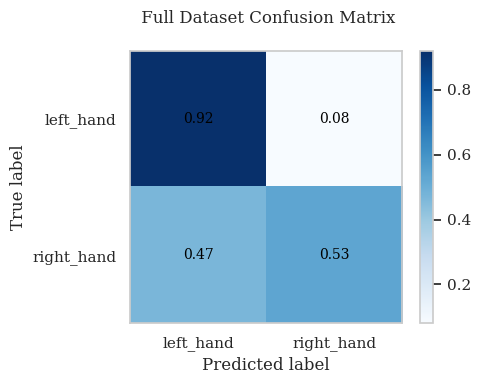

-----------------Validation Set Performance-------------------
Accuracy: 0.6923076923076923
Kappa: 0.3846153846153846
F1-Score: 0.5813953488372093
Sensitivity: 0.43859649122807015


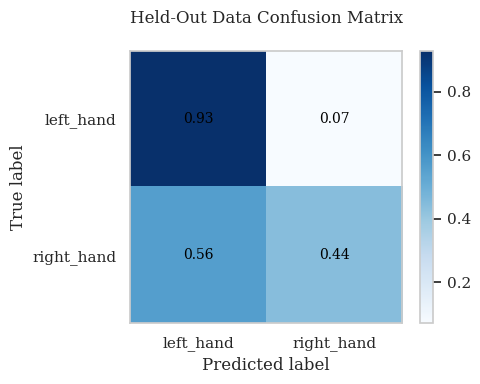

In [ ]:
# @title Pre-training

model.to(device)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
for train_idx, val_idx in sss.split(X_stft, Y):
  X_train, X_val = X_stft[train_idx], X_stft[val_idx]
  y_train, y_val = Y[train_idx], Y[val_idx]
val = elbowMIDataset(X_val, torch.tensor(y_val).long(), transform=None, augment_prob=0.0)
val_loader = DataLoader(val, batch_size=test_batch, shuffle=False)

best_F1 = 0
best_sensitivity = 0
best_acc = 0

n_fold_loops = 1
for fold_loop in range(n_fold_loops):
  clear_output()
  print(f"Training Fold Loop {fold_loop+1}/{n_fold_loops}")

  for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    x1, x2 = X_stft[train_idx], X_stft[test_idx]
    y1, y2 = Y[train_idx], Y[test_idx]

    train = elbowMIDataset(x1, torch.tensor(y1).long(), transform=None, augment_prob=0.0)
    test = elbowMIDataset(x2, torch.tensor(y2).long(), transform=None, augment_prob=0.0)

    # g = torch.Generator()
    # g.manual_seed(42)
    train_loader = DataLoader(train, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(test, batch_size=test_batch, shuffle=False)

    # @title Train
    for i in tqdm(range(n_iter), desc=f"Training: fold {fold+1}/{k}"):

      model.train()
      train_loss = 0
      train_acc = 0
      train_precision = 0
      for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        # print(f"Train: {torch.unique(y)}")
        optimizer.zero_grad()
        # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
        logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
        l2_penalty = sum((p**2).sum() for p in model.parameters())
        # cnt_loss = LAMBDA_CONTRAST*supervised_contrastive_loss(logits, y)
        # loss = loss + cnt_loss + l2_lambda*l2_penalty
        loss = loss + l2_lambda*l2_penalty

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
        optimizer.step()

        # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
        probs = torch.softmax(logits, dim=-1)
        probs = probs * PROBS_SCALE
        pred = torch.argmax(probs, dim=-1).cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        y_bin = label_binarize(y, classes=range(2))
        if np.isnan(pred).sum() >0:
          print(logits)
        train_precision += average_precision_score(y_bin, pred, average="micro")
        train_loss += loss.item()
        train_acc += acc.item()

      train_precision /= len(train_loader)
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)

      if i==0 or (i+1)%eval_inter==0 or i==n_iter-1:
        # model.load_state_dict(model_saver.best_state)
        model.eval()
        all_labels = []
        all_preds = []
        for j, (x, y) in enumerate(test_loader):
          x, y = x.to(device), y.to(device)
          with torch.no_grad():
            # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
            logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
            probs = torch.softmax(logits, dim=-1)
            probs = probs * PROBS_SCALE
            pred = torch.argmax(probs, dim=-1).cpu()
            y = y.cpu()

            all_labels.append(y)
            all_preds.append(pred)

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        fold_F1 = f1_score(all_labels, all_preds)
        fold_sensitivity = recall_score(all_labels, all_preds)
        fold_acc = acc_score(all_labels, all_preds)

        if (fold_F1 > best_F1) or (fold_sensitivity > best_sensitivity) or (fold_acc > best_acc):
          best_acc = acc_score(all_labels, all_preds)
          best_F1 = f1_score(all_labels, all_preds)
          best_sensitivity = recall_score(all_labels, all_preds)

          accuracy = acc_score(all_labels, all_preds)
          kappa = ((accuracy-0.5)/(1-0.5))
          F1 = f1_score(all_labels, all_preds)
          sensitivity = recall_score(all_labels, all_preds)
          print(f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")
          # model_saver.checkpoint(1-acc, model, message=f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")
          torch.save(model.state_dict(), "pretrained_model.pt")

data = elbowMIDataset(X_stft, torch.tensor(Y).long(), transform=None, augment_prob=0.0)
dataset_loader = DataLoader(data, batch_size=train_batch, shuffle=False)
model.eval()
weights = torch.load("pretrained_model.pt")
model.load_state_dict(weights)
model.to(device)
all_labels = []
all_preds = []
for j, (x, y) in enumerate(dataset_loader):
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
    logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
    probs = torch.softmax(logits, dim=-1)
    probs = probs * PROBS_SCALE
    pred = torch.argmax(probs, dim=-1).cpu()
    y = y.cpu()

    all_labels.append(y)
    all_preds.append(pred)

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

accuracy = acc_score(all_labels, all_preds)
kappa = ((accuracy-0.5)/(1-0.5))
F1 = f1_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds)

accuracy = np.round(accuracy, 2)
kappa = np.round(kappa, 2)
F1 = np.round(F1, 2)
sensitivity = np.round(sensitivity, 2)

print(" ")
print(f"Accuracy: {accuracy}")
print(f"Kappa: {kappa}")
print(f"F1-Score: {F1}")
print(f"Sensitivity: {sensitivity}")

cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(int)
cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
cm = np.round(cm, 2)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
# Add labels
ax.grid(False)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="black", fontsize=10)
# Axis labels & title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f" Full Dataset Confusion Matrix", pad=20)
# ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

fig.colorbar(im)
plt.tight_layout()
plt.savefig(f"pretrained_model_confusion_matrix.png", bbox_inches="tight", dpi=300)
plt.show()

print("-----------------Validation Set Performance-------------------" )
all_labels = []
all_preds = []
for j, (x, y) in enumerate(val_loader):
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
    logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
    probs = torch.softmax(logits, dim=-1)
    probs = probs * PROBS_SCALE
    pred = torch.argmax(probs, dim=-1).cpu()
    y = y.cpu()

    all_labels.append(y)
    all_preds.append(pred)

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)
# fold_F1 = f1_score(all_labels, all_preds)
fold_acc = acc_score(all_labels, all_preds)

accuracy = acc_score(all_labels, all_preds)
kappa = ((accuracy-0.5)/(1-0.5))
F1 = f1_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Kappa: {kappa}")
print(f"F1-Score: {F1}")
print(f"Sensitivity: {sensitivity}")

cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(int)
cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
cm = np.round(cm, 2)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
# Add labels
ax.grid(False)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="black", fontsize=10)
# Axis labels & title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Held-Out Data Confusion Matrix", pad=20)
# ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

fig.colorbar(im)
plt.tight_layout()
plt.savefig(f"held_out_set_confusion_matrix.png", bbox_inches="tight", dpi=300)
plt.show()



# time.sleep(5)
# clear_output()

In [ ]:
accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

In [ ]:
# @title Evaluate on Full Data Set

# model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
#                     n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
#                     dropout=_dropout)
# weights = torch.load("pretrained_model.pt")
# model.load_state_dict(weights)
model.to(device)
model.eval()

for s, subject in enumerate(subjects):
  print(f"Evaluating subject {subject}: {s+1}/{len(subjects)}")

  with contextlib.redirect_stdout(io.StringIO()):
    s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx]
  right_imagery = s_x[right_imagery_idx]
  s_x, s_y = 0, 0
  X_subject = np.vstack((left_imagery, right_imagery))
  Y_subject = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Subject Data Shape: {(X_subject.shape, Y_subject.shape)}")

  X_subject = mne.filter.filter_data(X_subject, fs, f1, f2)  # --> BandPass Filtering
  X_subject = X_subject - X_subject.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_subject_stft = []
  for epoch in tqdm(X_subject, total=X_subject.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_subject_stft.append(epoch_stft)
  X_subject_stft = np.array(X_subject_stft)
  print(f"Subject STFTs Shape: {(X_subject_stft.shape, Y_subject.shape)}")

  data = elbowMIDataset(X_subject_stft, torch.tensor(Y_subject).long())
  data_loader = DataLoader(data, batch_size=test_batch, shuffle=False)

  print("-----------------Subject Validation Performance-------------------" )
  weights = torch.load("pretrained_model.pt")
  model.load_state_dict(weights)
  model.to(device)
  model.eval()
  all_labels = []
  all_preds = []
  for j, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      # logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = torch.softmax(logits, dim=-1)
      probs = probs * PROBS_SCALE
      pred = torch.argmax(probs, dim=-1).cpu()
      y = y.cpu()

      all_labels.append(y)
      all_preds.append(pred)

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  # fold_F1 = f1_score(all_labels, all_preds)
  fold_acc = acc_score(all_labels, all_preds)

  subject_accuracy = acc_score(all_labels, all_preds)
  subject_kappa = ((subject_accuracy-0.5)/(1-0.5))
  subject_F1 = f1_score(all_labels, all_preds)
  subject_sensitivity = recall_score(all_labels, all_preds)

  print(f"Accuracy: {subject_accuracy}")
  print(f"Kappa: {subject_kappa}")
  print(f"F1-Score: {subject_F1}")
  print(f"Sensitivity: {subject_sensitivity}")

  accuracies[subject] = subject_accuracy
  kappas[subject] = subject_kappa
  F1s[subject] = subject_F1
  sensitivities[subject] = subject_sensitivity

  time.sleep(0.25)
  clear_output()

In [ ]:
# compute mean and std for accuracy and kappa
accuracies["Mean"] = np.round(np.mean(list(accuracies.values())), 2)
accuracies["Std"]  = np.round(np.std(list(accuracies.values())), 2)

kappas["Mean"] = np.round(np.mean(list(kappas.values())), 2)
kappas["Std"]  = np.round(np.std(list(kappas.values())), 2)

# compute mean and std for accuracy and kappa
F1s["Mean"] = np.round(np.mean(list(F1s.values())), 2)
F1s["Std"]  = np.round(np.std(list(F1s.values())), 2)

# compute mean and std for accuracy and kappa
sensitivities["Mean"] = np.round(np.mean(list(sensitivities.values())), 2)
sensitivities["Std"]  = np.round(np.std(list(sensitivities.values())), 2)

In [ ]:
# accuracies.pop("Mean")
# accuracies.pop("Std")

# kappas.pop("Mean")
# kappas.pop("Std")

# F1s.pop("Mean")
# F1s.pop("Std")

# sensitivities.pop("Mean")
# sensitivities.pop("Std")

In [ ]:
# @title .

# build DataFrame with subjects included
validation_df = pd.DataFrame({
    "Accuracy": pd.Series(accuracies),
    "Kappa": pd.Series(kappas),
    "F1-Score": pd.Series(F1s),
    "Sensitivity": pd.Series(sensitivities)
})

validation_df

,Accuracy,Kappa,F1-Score,Sensitivity
1,0.897436,0.794872,0.894737,0.894737
2,0.923077,0.846154,0.918919,0.894737
3,0.846154,0.692308,0.850000,0.894737
4,0.974359,0.948718,0.974359,1.000000
5,0.974359,0.948718,0.974359,1.000000
6,0.487179,-0.025641,0.166667,0.105263
7,0.538462,0.076923,0.100000,0.052632
8,0.641026,0.282051,0.461538,0.315789
9,0.538462,0.076923,0.100000,0.052632
10,0.512821,0.025641,0.173913,0.105263


In [ ]:
# ! rm -rf experiments/

In [ ]:
# @title Save Experiment Parameters & Artifacts

import shutil

exp_name = "Exp_2.1:run_11"
exp_data = {
    "base_experiment": "Exp_2.1:run_3",
    "dataset": "Liu2024",
    "channels": {"method": "Selection", "names":["C3", "C4", "Cz"]},
    "feature-engineering": {
        "BandPass-Filter": {"low":float(f1), "high":float(f2)},
        "Epoch_Processing": "Time-points Detrending (Across Channels)",
        "STFT": {"W":W, "window_type": "cosine", "HOP":hop_, "fs": fs, "NFFT": nfft, "method":"scipy.ShortTimeFFT.spectrogram"},
        # "Spectrogram_Scaling": None,
        # "Spectrogram_Scaling": {"Type":"Min-Max", "Axis":"Trials (Epochs)"}
        "Spectrogram_Scaling": {"Type":"Min-Max", "Axis":"Channels"}
    },
    "augmentation": None,
    "model": {"name":"SPEC_CNN_T1", "parameters":{
        "d_in":_d_in, "d_model":_d_model, "n_tokens":_n_tokens,
        "num_heads":_num_heads, "d_ff":_d_ff,
        "n_layers":_n_layers, "dropout":_dropout
    }},
    "optimizer": {
        "method":"Adam", "lr": 3E-4,
        "betas": [0.9, 0.99], "weight_decay":1E-4},
    "lr_scheduler": None,
    "regularization": {
        "weight_decay": 1E-4,
        "L2": l2_lambda,
        "EntropyLabelSmooth": LBL_SMOOTH,
    },
    "loss": "CrossEntropyLoss",
    "labels": classes,
    "across_subjects_performance": {
        "meanAccuracy":float(accuracies["Mean"]), "meanKappa":float(kappas["Mean"]),
        "meanF1":float(F1s["Mean"]), "meanSensitivity":float(sensitivities["Mean"]),
        "stdAccuracy":float(accuracies["Std"]), "stdKappa":float(kappas["Std"]),
        "stdF1":float(F1s["Std"]), "stdSensitivity":float(sensitivities["Std"])},
    "validation_set_performance": {
        "accuracy": float(accuracy), "kappa": float(kappa),
        "F1": float(F1), "sensitivity": float(sensitivity)
    },
    "N_Kfolds": k,
}

if ~os.path.exists(f"experiments/{exp_name}"):
  os.makedirs(f"experiments/{exp_name}")

if ~os.path.exists(f"experiments/{exp_name}/run.yaml"):
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    f.write(yaml.dump(exp_data))
    f.close()
else:
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    existing_data = yaml.load(f)
    existing_data.update(exp_data)
    f.write(yaml.dump(existing_data))
    f.close()

validation_df.to_csv(f"experiments/{exp_name}/subjects_validation_df.csv", index=False)

# for subject in subjects:
#   shutil.copy(f"subject_{subject}_train_set_confusion_matrix.png", f"experiments/{exp_name}/")
#   shutil.copy(f"subject_{subject}_test_set_confusion_matrix.png", f"experiments/{exp_name}/")
shutil.copy(f"pretrained_model_confusion_matrix.png", f"experiments/{exp_name}/")
shutil.copy(f"held_out_set_confusion_matrix.png", f"experiments/{exp_name}/")
shutil.copy(f"pretrained_model.pt", f"experiments/{exp_name}/")

print(f"Experiment saved at: experiments/{exp_name}")

Experiment saved at: experiments/Exp_2.1:run_11


In [ ]:
# @title Download Artifacts

!zip -r experiments.zip experiments/

from google.colab import files
files.download("experiments.zip")

  adding: experiments/ (stored 0%)
  adding: experiments/Exp_2.1:run_11/ (stored 0%)
  adding: experiments/Exp_2.1:run_11/run.yaml (deflated 46%)
  adding: experiments/Exp_2.1:run_11/pretrained_model.pt (deflated 7%)
  adding: experiments/Exp_2.1:run_11/subjects_validation_df.csv (deflated 75%)
  adding: experiments/Exp_2.1:run_11/pretrained_model_confusion_matrix.png (deflated 16%)
  adding: experiments/Exp_2.1:run_11/held_out_set_confusion_matrix.png (deflated 16%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fine-Tuning

In [ ]:
base_exp_name = "Exp_2.1:run_11"
! mkdir -p experiments/alt_experiments/$base_exp_name

In [ ]:
# @title Functions

import torch
import torch.nn.functional as F

def supervised_contrastive_loss(features, labels, temperature=0.1):
  """
  features: [B, E] - your embeddings
  labels: [B] or [B, 1] - binary labels (0/1)
  """
  device = features.device
  batch_size = features.shape[0]

  # Normalize features
  features = F.normalize(features, dim=1)

  # Compute similarity matrix
  similarity_matrix = torch.matmul(features, features.T) / temperature

  # Create mask for positive pairs (same class)
  labels = labels.view(-1, 1)
  mask = torch.eq(labels, labels.T).float().to(device)

  # Remove self-similarity
  mask = mask - torch.eye(batch_size).to(device)

  # Compute exp of similarities
  exp_sim = torch.exp(similarity_matrix)

  # Sum of exp similarities for normalization
  sum_exp_sim = exp_sim.sum(dim=1, keepdim=True) - torch.diag(exp_sim).unsqueeze(1)

  # Positive pairs
  pos_sim = exp_sim * mask

  # Contrastive loss
  loss = -torch.log((pos_sim.sum(dim=1) + 1e-8) / (sum_exp_sim + 1e-8))

  return loss.mean()

In [ ]:
# @title Fine-Tuning Parameters

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

_d_in = 39
_d_model = 512
_num_heads = 8
_n_layers = 2
_n_tokens = 17
_d_ff = 1024
_dropout_ = 0.3
model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout_)
for param in model.backbone.parameters():
  param.requires_grad = True
for layer in [model.backbone.conv11, model.backbone.relu11, model.backbone.avgpool11]:
  for param in layer.parameters():
    param.requires_grad = True
for layer in [model.backbone.conv21, model.backbone.relu21, model.backbone.avgpool21]:
  for param in layer.parameters():
    param.requires_grad = True
for layer in [model.backbone.conv31, model.backbone.relu31, model.backbone.avgpool31]:
  for param in layer.parameters():
    param.requires_grad = True
for param in model.embedding.parameters():
  param.requires_grad = True
for param in model.enc1.parameters():
  param.requires_grad = True
for param in model.fc.parameters():
  param.requires_grad = True

n_iter = 100
eval_inter = 5
train_batch = 80
test_batch = 20

lr_ = 3E-4
momentum_ = 0.0
betas_ = (0.9, 0.99)
lr_defs = [
    {"params": list(model.backbone.conv11.parameters()) +
               list(model.backbone.relu11.parameters()) +
               list(model.backbone.avgpool11.parameters()), "lr": lr_/27},
    {"params": list(model.backbone.conv21.parameters()) +
               list(model.backbone.relu21.parameters()) +
               list(model.backbone.avgpool21.parameters()), "lr": lr_/27},
    {"params": list(model.backbone.conv31.parameters()) +
               list(model.backbone.relu31.parameters()) +
               list(model.backbone.avgpool31.parameters()), "lr": lr_/27},
    {"params": list(model.embedding.parameters()) +
               list(model.embedding_relu.parameters()), "lr": lr_/9},
    {"params": model.enc1.parameters(), "lr": lr_/9},
    {"params": model.fc.parameters(), "lr": lr_/3},
]
optimizer = torch.optim.Adam(lr_defs, betas=betas_, weight_decay=1E-4)
PROBS_SCALE = torch.tensor([0.15, 0.85]).to(device)

PRETRAINED_MODEL_DIR = f"experiments/{base_exp_name}/pretrained_model.pt"
weights = torch.load(PRETRAINED_MODEL_DIR)
model.load_state_dict(weights)
model.probs_param = nn.Parameter((torch.randn(2, 2)))


# augment = Compose([
#     Masking(channel_dropout_prob=0.1, time_mask_width=10, freq_mask_width=12),
#     TimeShifting(max_shift_ratio=0.08),
#     NoiseAugmentation(noise_types=['gaussian'], gaussian_std_range=(0.005, 0.02))
# ])

LBL_SMOOTH = 0.3
l2_lambda = 1E-4
CHKPT_MARGIN = 0.05
LAMBDA_CONTRAST = 0.6

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Create early stopping and checkpointing instances
# early_stopper = EarlyStopping(patience=5, min_delta=0.01)
model_saver = CheckpointModel(margin=0.0)

def fine_tune_run(model, x, y=None, transforms=None, LBL_SMOOTH=0.0):
  if transforms is not None:
    x = transforms(x)

  embeddings = model.get_embedding(x)
  cls_token = embeddings[:, 0, :]
  logits = model.fc(cls_token)
  if y is not None:
    # y = y.unsqueeze(1)
    # y = y.to(torch.float)
    logits = torch.matmul(logits, F.softmax(model.probs_param).T)
    loss = F.cross_entropy(logits, y, label_smoothing=LBL_SMOOTH)
    acc = accuracy_score(logits, y)
    return logits, cls_token, loss, acc
  return logits, cls_token, loss, acc

In [ ]:
augment_subjects = subjects[0:10]
fine_tune_subjects = subjects[10:]
pre_train_subjects = [sub for sub in subjects if sub not in fine_tune_subjects]

In [ ]:
accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

In [ ]:
# @title Make Augmentation Data
with contextlib.redirect_stdout(io.StringIO()):
  s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=augment_subjects)
# time.sleep(0.25)
# clear_output()
left_imagery_idx = np.where(s_y=='left_hand')[0]
right_imagery_idx = np.where(s_y=='right_hand')[0]
left_imagery = s_x[left_imagery_idx]
right_imagery = s_x[right_imagery_idx]
s_x, s_y = 0, 0
X_aug = np.vstack((left_imagery, right_imagery))
Y_aug = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))

X_aug = mne.filter.filter_data(X_aug, fs, f1, f2) # --> BandPass Filtering
X_aug = X_aug - X_aug.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

X_aug_stft = []
for epoch in tqdm(X_aug, total=X_aug.shape[0], desc="Generating Train set STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  X_aug_stft.append(epoch_stft)
X_aug_stft = np.array(X_aug_stft)
print(f"Training Epochs Shape: {(X_aug.shape, Y_aug.shape)}")
print(f"STFT Epochs Shape: {(X_aug_stft.shape, Y_aug.shape)}")
print("----------------------------------------------------")

Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 s)



Generating Train set STFTs: 100%|██████████| 390/390 [00:08<00:00, 43.73it/s]

Training Epochs Shape: ((390, 3, 1000), (390,))
STFT Epochs Shape: ((390, 3, 122, 156), (390,))
----------------------------------------------------


In [ ]:
# @title Fine Tune

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
model.to(device)

for s, subject in enumerate(fine_tune_subjects):
  print(f"Fine-tuning for subject {subject}: {s+1}/{len(fine_tune_subjects)}")

  best_F1 = 0
  best_acc = 0
  best_sensitivity = 0


  with contextlib.redirect_stdout(io.StringIO()):
    s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx]
  right_imagery = s_x[right_imagery_idx]
  s_x, s_y = 0, 0
  X_subject = np.vstack((left_imagery, right_imagery))
  Y_subject = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Subject Data Shape: {(X_subject.shape, Y_subject.shape)}")

  X_subject = mne.filter.filter_data(X_subject, fs, f1, f2)  # --> BandPass Filtering
  X_subject = X_subject - X_subject.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_subject_stft = []
  for epoch in tqdm(X_subject, total=X_subject.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_subject_stft.append(epoch_stft)
  X_subject_stft = np.array(X_subject_stft)
  print(f"Subject STFTs Shape: {(X_subject_stft.shape, Y_subject.shape)}")

  # @title Make Dataset
  weights = torch.load(PRETRAINED_MODEL_DIR)
  weights["probs_param"] = model.probs_param.cpu()
  model.load_state_dict(weights)
  model.to(device)
  model.train()

  n_fold_loops = 1
  for fold_loop in range(n_fold_loops):
    clear_output()
    print(f"Training Fold Loop {fold_loop+1}/{n_fold_loops} for subject-{subject} ({s+1}/{len(fine_tune_subjects)})")

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, test_idx in sss.split(X_subject_stft, Y_subject):
      X_train_stft, X_val_stft = X_subject_stft[train_idx], X_subject_stft[test_idx]
      y_train, y_val = Y_subject[train_idx], Y_subject[test_idx]
    val = elbowMIDataset(X_val_stft, torch.tensor(y_val).long())
    val_loader = DataLoader(val, batch_size=test_batch, shuffle=False)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_stft, y_train)):
      x1, x2 = X_train_stft[train_idx], X_train_stft[test_idx]    # --> Get subject train (x1, y1) and test (x2, y2) for each fold
      y1, y2 = y_train[train_idx], y_train[test_idx]
      g = torch.Generator()
      g.manual_seed(42)
      test = elbowMIDataset(x2, torch.tensor(y2).long(), transform=None, augment_prob=0.0)
      test_loader = DataLoader(test, batch_size=train_batch, shuffle=False)

      oss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=None)
      for train_idx, test_idx in oss.split(X_aug_stft, Y_aug):
        x3, y3 = X_aug_stft[test_idx], Y_aug[test_idx]    # --> Augment subject train with (x3, y3) from opeen dataset
        # print(f"subject Shape: {(x1.shape, x2.shape)}, Augment Shape: {x3.shape}")
      x1 = np.vstack((x1, x3))
      y1 = np.hstack((y1, y3))
      train = elbowMIDataset(x1, torch.tensor(y1).long(), transform=None, augment_prob=0.0)
      train_loader = DataLoader(train, batch_size=train_batch, shuffle=True)

      # @title Train
      for i in tqdm(range(n_iter), desc=f"Training Fold {fold+1}/{k}", total=n_iter):

        model.train()
        train_loss = 0
        train_acc = 0
        train_precision = 0
        for j, (x, y) in enumerate(train_loader):
          x, y = x.to(device), y.to(device)
          # print(f"Train: {torch.unique(y)}")
          optimizer.zero_grad()
          logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
          # logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
          l2_penalty = sum((p**2).sum() for p in model.parameters())
          # cnt_loss = LAMBDA_CONTRAST*supervised_contrastive_loss(logits, y)
          # loss = loss + cnt_loss + l2_lambda*l2_penalty
          loss = loss + l2_lambda*l2_penalty

          loss.backward()
          # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
          optimizer.step()

          # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
          probs = torch.softmax(logits, dim=-1)
          # probs = probs * PROBS_SCALE
          pred = torch.argmax(probs, dim=-1).cpu().detach().numpy()
          y = y.cpu().detach().numpy()
          y_bin = label_binarize(y, classes=range(2))
          if np.isnan(pred).sum() >0:
            print(logits)
          train_precision += average_precision_score(y_bin, pred, average="micro")
          train_loss += loss.item()
          train_acc += acc.item()

        train_precision /= len(train_loader)
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        if i==0 or (i+1)%eval_inter==0 or i==n_iter-1:
          # model.load_state_dict(model_saver.best_state)
          model.eval()
          all_labels = []
          all_preds = []
          for j, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
              logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
              # logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
              probs = torch.softmax(logits, dim=-1)
              # probs = probs * PROBS_SCALE
              pred = torch.argmax(probs, dim=-1).cpu()
              y = y.cpu()

              all_labels.append(y)
              all_preds.append(pred)

          all_labels = torch.cat(all_labels)
          all_preds = torch.cat(all_preds)
          fold_F1 = f1_score(all_labels, all_preds)
          fold_sensitivity = recall_score(all_labels, all_preds)
          fold_acc = acc_score(all_labels, all_preds)

          if (fold_acc > best_acc): #(fold_F1 > best_F1) or (fold_sensitivity > best_sensitivity) or
            best_acc = acc_score(all_labels, all_preds)
            best_F1 = f1_score(all_labels, all_preds)
            best_sensitivity = recall_score(all_labels, all_preds)

            accuracy = acc_score(all_labels, all_preds) * 100
            kappa = (((accuracy/100)-0.5)/(1-0.5))
            F1 = f1_score(all_labels, all_preds) * 100
            sensitivity = recall_score(all_labels, all_preds) * 100

            print(f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")
            best_weights = model.state_dict()
            # model_saver.checkpoint(1-acc, model, message=f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")

            # accuracies[subject] = accuracy
            # kappas[subject] = kappa
            # F1s[subject] = F1
            # sensitivities[subject] = sensitivity

  # print(" ")
  # print(f"Subject Accuracy: {round(accuracies[subject], 2)}")
  # print(f"subject Kappa: {round(kappas[subject], 2)}")
  # print(f"Subject F1-Score: {round(F1s[subject], 2)}")
  # print(f"subject Sensitivity: {round(sensitivities[subject], 2)}")
  print("-----------------Subject Validation Performance-------------------" )
  data = elbowMIDataset(X_subject_stft, torch.tensor(Y_subject).long())
  data_loader = DataLoader(data, batch_size=test_batch, shuffle=False, generator=g)

  model.load_state_dict(best_weights)
  model.eval()
  all_labels = []
  all_preds = []
  for j, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      # logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = torch.softmax(logits, dim=-1)
      # probs = probs * PROBS_SCALE
      pred = torch.argmax(probs, dim=-1).cpu()
      y = y.cpu()

      all_labels.append(y)
      all_preds.append(pred)

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  # fold_F1 = f1_score(all_labels, all_preds)
  fold_acc = acc_score(all_labels, all_preds)

  accuracy = acc_score(all_labels, all_preds)
  kappa = ((accuracy-0.5)/(1-0.5))
  F1 = f1_score(all_labels, all_preds)
  sensitivity = recall_score(all_labels, all_preds)

  print(f"Accuracy: {accuracy}")
  print(f"Kappa: {kappa}")
  print(f"F1-Score: {F1}")
  print(f"Sensitivity: {sensitivity}")

  accuracies[subject] = accuracy
  kappas[subject] = kappa
  F1s[subject] = F1
  sensitivities[subject] = sensitivity

  time.sleep(0.25)
  clear_output()

In [ ]:
pre_train_subjects

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
# @title Evaluate on Train Set

model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout)
weights = torch.load(PRETRAINED_MODEL_DIR)
model.load_state_dict(weights)
model.to(device)
model.eval()

for s, subject in enumerate(pre_train_subjects):
  print(f"Evaluating subject {subject}: {s+1}/{len(pre_train_subjects)}")

  with contextlib.redirect_stdout(io.StringIO()):
    s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx]
  right_imagery = s_x[right_imagery_idx]
  s_x, s_y = 0, 0
  X_subject = np.vstack((left_imagery, right_imagery))
  Y_subject = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Subject Data Shape: {(X_subject.shape, Y_subject.shape)}")

  X_subject = mne.filter.filter_data(X_subject, fs, f1, f2)  # --> BandPass Filtering
  X_subject = X_subject - X_subject.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_subject_stft = []
  for epoch in tqdm(X_subject, total=X_subject.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_subject_stft.append(epoch_stft)
  X_subject_stft = np.array(X_subject_stft)
  print(f"Subject STFTs Shape: {(X_subject_stft.shape, Y_subject.shape)}")

  data = elbowMIDataset(X_subject_stft, torch.tensor(Y_subject).long())
  data_loader = DataLoader(data, batch_size=test_batch, shuffle=False, generator=g)

  print("-----------------Subject Validation Performance-------------------" )
  all_labels = []
  all_preds = []
  for j, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      # logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = torch.softmax(logits, dim=-1)
      # probs = probs * PROBS_SCALE
      pred = torch.argmax(probs, dim=-1).cpu()
      y = y.cpu()

      all_labels.append(y)
      all_preds.append(pred)

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  # fold_F1 = f1_score(all_labels, all_preds)
  fold_acc = acc_score(all_labels, all_preds)

  accuracy = acc_score(all_labels, all_preds)
  kappa = ((accuracy-0.5)/(1-0.5))
  F1 = f1_score(all_labels, all_preds)
  sensitivity = recall_score(all_labels, all_preds)

  print(f"Accuracy: {accuracy}")
  print(f"Kappa: {kappa}")
  print(f"F1-Score: {F1}")
  print(f"Sensitivity: {sensitivity}")

  accuracies[subject] = accuracy
  kappas[subject] = kappa
  F1s[subject] = F1
  sensitivities[subject] = sensitivity

  time.sleep(0.25)
  clear_output()

In [ ]:
# compute mean and std for accuracy and kappa
accuracies["Mean"] = np.round(np.mean(list(accuracies.values())), 2)
accuracies["Std"]  = np.round(np.std(list(accuracies.values())), 2)

kappas["Mean"] = np.round(np.mean(list(kappas.values())), 2)
kappas["Std"]  = np.round(np.std(list(kappas.values())), 2)

# compute mean and std for accuracy and kappa
F1s["Mean"] = np.round(np.mean(list(F1s.values())), 2)
F1s["Std"]  = np.round(np.std(list(F1s.values())), 2)

# compute mean and std for accuracy and kappa
sensitivities["Mean"] = np.round(np.mean(list(sensitivities.values())), 2)
sensitivities["Std"]  = np.round(np.std(list(sensitivities.values())), 2)

In [ ]:
# accuracies.pop("Mean")
# accuracies.pop("Std")

# kappas.pop("Mean")
# kappas.pop("Std")

# F1s.pop("Mean")
# F1s.pop("Std")

# sensitivities.pop("Mean")
# sensitivities.pop("Std")

In [ ]:
# @title .

# build DataFrame with subjects included
validation_df = pd.DataFrame({
    "Accuracy": pd.Series(accuracies),
    "Kappa": pd.Series(kappas),
    "F1-Score": pd.Series(F1s),
    "Sensitivity": pd.Series(sensitivities)
})

validation_df

,Accuracy,Kappa,F1-Score,Sensitivity
11,0.846154,0.692308,0.842105,0.842105
12,0.820513,0.641026,0.820513,0.842105
13,0.512821,0.025641,0.000000,0.000000
14,0.923077,0.846154,0.918919,0.894737
15,0.641026,0.282051,0.650000,0.684211
16,0.846154,0.692308,0.842105,0.842105
1,0.897436,0.794872,0.894737,0.894737
2,0.923077,0.846154,0.918919,0.894737
3,0.820513,0.641026,0.820513,0.842105
4,0.974359,0.948718,0.974359,1.000000


In [ ]:
# ! rm -rf experiments/Exp_2.2:run_3

In [ ]:
# @title Save Experiment Parameters & Artifacts

import shutil

exp_name = "Exp_2.2:run_8"
exp_data = {
    "base_experiment": "Exp_2.1:run_11",
    "dataset": "BCI Competition IV Dataset-2b",
    "channels": {"method": "Selection", "names":["C3", "C4", "Cz"]},
    "feature-engineering": {
        "BandPass-Filter": {"low":float(f1), "high":float(f2)},
        "Epoch_Processing": "Time-points Detrending (Across Channels)",
        "STFT": {"W":W, "window_type": "cosine", "HOP":hop_, "fs": fs, "NFFT":nfft, "method":"scipy.ShorTimeFFT.spectrogram"},
        "Spectrogram_Scaling": None,
    },
    "augmentation": None,
    "model": {"name":"SPEC_CNN_T1", "parameters":{
        "d_in":_d_in, "d_model":_d_model, "n_tokens":_n_tokens,
        "num_heads":_num_heads, "d_ff":_d_ff,
        "n_layers":_n_layers, "fine_tune_dropout":_dropout_,
        "pre_train_dropout":_dropout,
    }},
    "optimizer": {
        "method":"Adam", "lr": 3E-5,
        "betas": [0.9, 0.99], "weight_decay":1E-4},
    "lr_scheduler": None,
    "regularization": {
        "weight_decay": 1E-4,
        "L2": l2_lambda,
        "EntropyLabelSmooth": LBL_SMOOTH,
    },
    "loss": "CrossEntropyLoss",
    "labels": ["Left Imagery", "Right Imagery"],
    "N_Kfolds": k,
}

if ~os.path.exists(f"experiments/alt_experiments/{exp_name}"):
  os.makedirs(f"experiments/alt_experiments/{exp_name}")

if ~os.path.exists(f"experiments/alt_experiments/{exp_name}/run.yaml"):
  with open(f"experiments/alt_experiments/{exp_name}/run.yaml", "w") as f:
    f.write(yaml.dump(exp_data))
    f.close()
else:
  with open(f"experiments/alt_experiments/{exp_name}/run.yaml", "w") as f:
    existing_data = yaml.load(f)
    existing_data.update(exp_data)
    f.write(yaml.dump(existing_data))
    f.close()

validation_df.to_csv(f"experiments/alt_experiments/{exp_name}/subjects_validation_df.csv", index=False)

print(f"Experiment saved at: experiments/alt_experiments/{exp_name}")

Experiment saved at: experiments/alt_experiments/Exp_2.2:run_8


In [ ]:
# @title Download Artifacts

!zip -r experiments.zip experiments/

from google.colab import files
files.download("experiments.zip")

updating: experiments/ (stored 0%)
updating: experiments/Exp_2.1:run_11/ (stored 0%)
updating: experiments/Exp_2.1:run_11/run.yaml (deflated 46%)
updating: experiments/Exp_2.1:run_11/pretrained_model.pt (deflated 7%)
updating: experiments/Exp_2.1:run_11/subjects_validation_df.csv (deflated 75%)
updating: experiments/Exp_2.1:run_11/pretrained_model_confusion_matrix.png (deflated 16%)
updating: experiments/Exp_2.1:run_11/held_out_set_confusion_matrix.png (deflated 16%)
  adding: experiments/alt_experiments/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.1:run_11/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.2:run_6/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.2:run_6/run.yaml (deflated 42%)
  adding: experiments/alt_experiments/Exp_2.2:run_6/subjects_validation_df.csv (deflated 75%)
  adding: experiments/alt_experiments/Exp_2.2:run_8/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.2:run_8/run.yaml (deflated 42%)
  adding: experiments/alt_experimen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Left vs Right Motor-Imagery Classification
- BCI Competition IV Dataset-2b

In [ ]:
# @title Load Modules

import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcdefaults()  # reset to Matplotlib defaults

from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")

from sklearn.metrics import average_precision_score, f1_score, confusion_matrix
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.metrics import accuracy_score as acc_score
import seaborn as sns


from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

In [ ]:
# @title Load Dataset Configs

from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery

dataset = BNCI2014_001()
paradigm = MotorImagery(channels=['C3', 'C4', 'Cz'], resample=250)

raw = dataset.get_data(subjects=[1])
fs = raw[1]['0train']['0'].info['sfreq']
channels = chs = raw[1]['0train']['0'].ch_names
channels_idx = chs_idx = list(range(len(channels)))
channel_types = ch_tps = raw[1]['0train']['0'].get_channel_types()
channels_map = dict(zip(channels, channels_idx))

choi = [channels_map['C3'], channels_map['C4'], channels_map['Cz']]

subjects = dataset.subject_list
print(f"No of Subjects: {len(subjects)}")

classes = list(dataset.event_id.keys())[0:2]
print(f"Classes: {classes}")

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|█████████████████████████████████████| 42.8M/42.8M [00:00<00:00, 59.4GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.8M/43.8M [00:00<00:00, 16.9GB/s]
SHA256 hash of downloaded file: 53d415f39c3d7b0c88b894d7b08d99bcdfe855ede63831d3691af1a45607fb62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


No of Subjects: 9
Classes: ['left_hand', 'right_hand']


In [ ]:
# @title STFT Configurations

from scipy.signal.windows import hann, cosine
from scipy.signal import ShortTimeFFT
from mne.time_frequency import stft

rescale_factor = 250 / fs
fs_ = fs * rescale_factor

# --> MNE Configurations
# W = 512
# hop_ = 8

# --> Scipy Configurations
N = fs_*4
W = 256
window = cosine(W, sym=False)
# window = hann(W, sym=False)
hop_ = 8
nfft = 4*W #5*W
f1, f2 = 0.1, 30

SFT = ShortTimeFFT(window, hop_, fs_, mfft=nfft, scale_to='magnitude')
freqs = (SFT.f>=f1) & (SFT.f<=f2)
n_freqs = len(SFT.f[freqs])
n_times = np.ceil((N + W)/hop_).astype(int).item()
print(f"(f, n): {(n_freqs, n_times)}")

(f, n): (122, 157)


#### Pre-Training

In [ ]:
# @title Training Parameters

accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model = BACKBONE_CNN()
# model = SPEC_CNN()
_d_in = 39
_d_model = 512
_n_tokens = 17
_num_heads = 8
_d_ff = 1024
_n_layers = 2
_dropout = 0.6
# model = SPEC_CNN_T1(d_in=42, d_model=256, num_heads=8, n_layers=2, n_tokens=14, d_ff=1024, dropout=0.6)
model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout)
init_weights_kaiming_normal(model, seed=SEED)

n_iter = 100
eval_inter = 5
train_batch = 500
test_batch = 126

lr_ = 3E-4
momentum_ = 0.0
betas_ = (0.9, 0.99)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_, betas=betas_, weight_decay=1E-4)
PROBS_SCALE = torch.tensor([0.4, 0.6]).to(device)

LBL_SMOOTH = 0.3
l2_lambda = 1E-4
CHKPT_MARGIN = 0.05

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

In [ ]:
# with contextlib.redirect_stdout(io.StringIO()):
#   x_ = torch.randn((2, 3, int(fs_*4)))
# x_ = twfb.fit_transform(x_.cpu().numpy().astype(float))
# clear_output()
# x_ = torch.tensor(x_).float()
# x_ = rearrange(x_, 'b w c t -> b c w t')
# # x_.size()

# # res = model.backbone(x_)
# res = model(x_)
# res.size()

In [ ]:
x_ = torch.randn((5, 3, n_freqs, n_times))
# res = model.backbone(x_)
res = model(x_)
res.size()

torch.Size([5, 2])

In [ ]:
model

SPEC_CNN_T1(
  (backbone): BACKBONE_CNN(
    (in_btn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv11): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu11): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn11): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv21): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu21): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn21): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool21): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv31): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu31): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn31): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool31): AvgPool2d(kernel_size=(2, 2)

In [ ]:
subjects

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# @title Make Pre-Training Data

pre_train_subjects = subjects[0:6]
with contextlib.redirect_stdout(io.StringIO()):
  s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=pre_train_subjects)
# time.sleep(0.25)
# clear_output()
left_imagery_idx = np.where(s_y=='left_hand')[0]
right_imagery_idx = np.where(s_y=='right_hand')[0]
left_imagery = s_x[left_imagery_idx]
right_imagery = s_x[right_imagery_idx]
s_x, s_y = 0, 0
X = np.vstack((left_imagery, right_imagery))
Y = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))

X = mne.filter.filter_data(X, fs, f1, f2) # --> BandPass Filtering
X = X - X.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

# @title STFT Feature Computation
X_stft = []
for epoch in tqdm(X, total=X.shape[0], desc="Generating Train set STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  X_stft.append(epoch_stft)
X_stft = np.array(X_stft)
# X_stft = twfb.fit_transform(X)
# X_stft = np.transpose(X_stft, [0, 2, 1, 3])
clear_output()
print(f"Training Epochs Shape: {(X.shape, Y.shape)}")
print(f"STFT Epochs Shape: {(X_stft.shape, Y.shape)}")
print("----------------------------------------------------")

Training Epochs Shape: ((1728, 3, 1001), (1728,))
STFT Epochs Shape: ((1728, 3, 122, 157), (1728,))
----------------------------------------------------


In [ ]:
classes

['left_hand', 'right_hand']

Training Fold Loop 1/1


Training: fold 1/5:   1%|          | 1/100 [00:00<01:24,  1.17it/s]

Model Checkpoint @ Acc:0.7066115702479339, Kappa:0.4132231404958677, F1:0.0, Sensitivity:0.0


Training: fold 1/5:   5%|▌         | 5/100 [00:03<01:18,  1.21it/s]

Model Checkpoint @ Acc:0.5, Kappa:0.0, F1:0.37305699481865284, Sensitivity:0.5070422535211268


Training: fold 1/5:  10%|█         | 10/100 [00:06<00:58,  1.54it/s]

Model Checkpoint @ Acc:0.7066115702479339, Kappa:0.4132231404958677, F1:0.0, Sensitivity:0.0


Training: fold 1/5:  35%|███▌      | 35/100 [00:22<00:40,  1.62it/s]

Model Checkpoint @ Acc:0.6859504132231405, Kappa:0.3719008264462811, F1:0.20833333333333334, Sensitivity:0.14084507042253522


Training: fold 1/5:  40%|████      | 40/100 [00:25<00:38,  1.56it/s]

Model Checkpoint @ Acc:0.6611570247933884, Kappa:0.3223140495867769, F1:0.4383561643835616, Sensitivity:0.4507042253521127


Training: fold 1/5:  45%|████▌     | 45/100 [00:28<00:34,  1.59it/s]

Model Checkpoint @ Acc:0.640495867768595, Kappa:0.28099173553719003, F1:0.5084745762711864, Sensitivity:0.6338028169014085


Training: fold 1/5:  50%|█████     | 50/100 [00:31<00:30,  1.62it/s]

Model Checkpoint @ Acc:0.6157024793388429, Kappa:0.23140495867768585, F1:0.5326633165829145, Sensitivity:0.7464788732394366


Training: fold 1/5:  55%|█████▌    | 55/100 [00:34<00:27,  1.61it/s]

Model Checkpoint @ Acc:0.6652892561983471, Kappa:0.3305785123966942, F1:0.5668449197860963, Sensitivity:0.7464788732394366


Training: fold 1/5:  60%|██████    | 60/100 [00:37<00:25,  1.55it/s]

Model Checkpoint @ Acc:0.5909090909090909, Kappa:0.18181818181818188, F1:0.56, Sensitivity:0.8873239436619719


Training: fold 1/5:  65%|██████▌   | 65/100 [00:40<00:22,  1.59it/s]

Model Checkpoint @ Acc:0.6157024793388429, Kappa:0.23140495867768585, F1:0.5279187817258884, Sensitivity:0.7323943661971831


Training: fold 1/5:  80%|████████  | 80/100 [00:49<00:12,  1.55it/s]

Model Checkpoint @ Acc:0.628099173553719, Kappa:0.25619834710743805, F1:0.5054945054945055, Sensitivity:0.647887323943662


Training: fold 1/5:  85%|████████▌ | 85/100 [00:52<00:09,  1.59it/s]

Model Checkpoint @ Acc:0.5743801652892562, Kappa:0.14876033057851235, F1:0.507177033492823, Sensitivity:0.7464788732394366


Training: fold 1/5:  90%|█████████ | 90/100 [00:55<00:06,  1.61it/s]

Model Checkpoint @ Acc:0.5991735537190083, Kappa:0.19834710743801653, F1:0.5174129353233831, Sensitivity:0.7323943661971831


Training: fold 1/5:  95%|█████████▌| 95/100 [00:58<00:03,  1.61it/s]

Model Checkpoint @ Acc:0.6611570247933884, Kappa:0.3223140495867769, F1:0.5, Sensitivity:0.5774647887323944


Training: fold 1/5: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

Model Checkpoint @ Acc:0.5743801652892562, Kappa:0.14876033057851235, F1:0.5253456221198156, Sensitivity:0.8028169014084507



Training: fold 2/5:   1%|          | 1/100 [00:00<01:04,  1.54it/s]

Model Checkpoint @ Acc:0.8677685950413223, Kappa:0.7355371900826446, F1:0.8072289156626506, Sensitivity:0.8933333333333333


Training: fold 3/5:   1%|          | 1/100 [00:00<01:15,  1.31it/s]

Model Checkpoint @ Acc:0.9380165289256198, Kappa:0.8760330578512396, F1:0.8872180451127819, Sensitivity:0.9833333333333333


Training: fold 3/5:   5%|▌         | 5/100 [00:03<01:04,  1.48it/s]

Model Checkpoint @ Acc:0.9628099173553719, Kappa:0.9256198347107438, F1:0.928, Sensitivity:0.9666666666666667


Training: fold 3/5:  15%|█▌        | 15/100 [00:09<00:53,  1.58it/s]

Model Checkpoint @ Acc:0.8884297520661157, Kappa:0.7768595041322315, F1:0.8137931034482758, Sensitivity:0.9833333333333333


Training: fold 3/5:  25%|██▌       | 25/100 [00:16<00:49,  1.52it/s]

Model Checkpoint @ Acc:0.9214876033057852, Kappa:0.8429752066115703, F1:0.8571428571428571, Sensitivity:0.95


Training: fold 3/5:  30%|███       | 30/100 [00:19<00:44,  1.56it/s]

Model Checkpoint @ Acc:0.8884297520661157, Kappa:0.7768595041322315, F1:0.8137931034482758, Sensitivity:0.9833333333333333


Training: fold 3/5:  40%|████      | 40/100 [00:25<00:39,  1.51it/s]

Model Checkpoint @ Acc:0.8966942148760331, Kappa:0.7933884297520661, F1:0.8226950354609929, Sensitivity:0.9666666666666667


Training: fold 3/5:  55%|█████▌    | 55/100 [00:34<00:28,  1.58it/s]

Model Checkpoint @ Acc:0.9049586776859504, Kappa:0.8099173553719008, F1:0.8244274809160306, Sensitivity:0.9


Training: fold 3/5:  65%|██████▌   | 65/100 [00:41<00:22,  1.56it/s]

Model Checkpoint @ Acc:0.8677685950413223, Kappa:0.7355371900826446, F1:0.7808219178082192, Sensitivity:0.95


Training: fold 3/5:  90%|█████████ | 90/100 [00:56<00:06,  1.56it/s]

Model Checkpoint @ Acc:0.871900826446281, Kappa:0.743801652892562, F1:0.7832167832167832, Sensitivity:0.9333333333333333


Training: fold 4/5:   1%|          | 1/100 [00:00<01:04,  1.54it/s]

Model Checkpoint @ Acc:0.9917355371900827, Kappa:0.9834710743801653, F1:0.9848484848484849, Sensitivity:0.9701492537313433


Training: fold 4/5:   5%|▌         | 5/100 [00:02<00:57,  1.66it/s]

Model Checkpoint @ Acc:0.987603305785124, Kappa:0.975206611570248, F1:0.9777777777777777, Sensitivity:0.9850746268656716


Training: fold 5/5:   1%|          | 1/100 [00:00<01:16,  1.30it/s]

Model Checkpoint @ Acc:0.991701244813278, Kappa:0.9834024896265561, F1:0.9863013698630136, Sensitivity:1.0


Training: fold 5/5: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


 
Accuracy: 0.75
Kappa: 0.51
F1-Score: 0.68
Sensitivity: 0.53


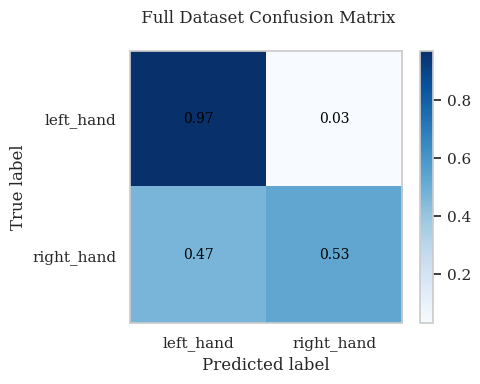

-----------------Validation Set Performance-------------------
Accuracy: 0.7649325626204239
Kappa: 0.5298651252408477
F1-Score: 0.6919191919191919
Sensitivity: 0.528957528957529


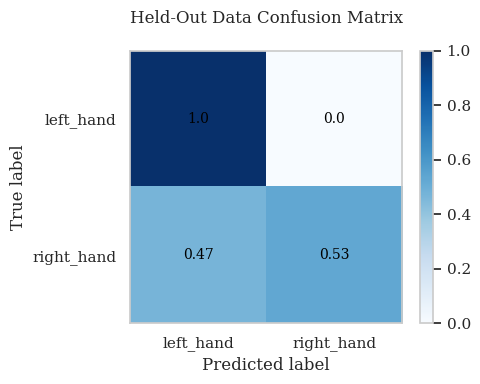

In [ ]:
# @title Pre-training

model.to(device)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
for train_idx, val_idx in sss.split(X_stft, Y):
  X_train, X_val = X_stft[train_idx], X_stft[val_idx]
  y_train, y_val = Y[train_idx], Y[val_idx]
val = elbowMIDataset(X_val, torch.tensor(y_val).long(), transform=None, augment_prob=0.0)
val_loader = DataLoader(val, batch_size=test_batch, shuffle=False)

best_F1 = 0
best_sensitivity = 0
best_acc = 0

n_fold_loops = 1
for fold_loop in range(n_fold_loops):
  clear_output()
  print(f"Training Fold Loop {fold_loop+1}/{n_fold_loops}")

  for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    x1, x2 = X_stft[train_idx], X_stft[test_idx]
    y1, y2 = Y[train_idx], Y[test_idx]

    train = elbowMIDataset(x1, torch.tensor(y1).long(), transform=None, augment_prob=0.0)
    test = elbowMIDataset(x2, torch.tensor(y2).long(), transform=None, augment_prob=0.0)

    # g = torch.Generator()
    # g.manual_seed(42)
    train_loader = DataLoader(train, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(test, batch_size=test_batch, shuffle=False)

    # @title Train
    for i in tqdm(range(n_iter), desc=f"Training: fold {fold+1}/{k}"):

      model.train()
      train_loss = 0
      train_acc = 0
      train_precision = 0
      for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        # print(f"Train: {torch.unique(y)}")
        optimizer.zero_grad()
        # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
        logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
        l2_penalty = sum((p**2).sum() for p in model.parameters())
        # cnt_loss = LAMBDA_CONTRAST*supervised_contrastive_loss(logits, y)
        # loss = loss + cnt_loss + l2_lambda*l2_penalty
        loss = loss + l2_lambda*l2_penalty

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
        optimizer.step()

        # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
        probs = torch.softmax(logits, dim=-1)
        probs = probs * PROBS_SCALE
        pred = torch.argmax(probs, dim=-1).cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        y_bin = label_binarize(y, classes=range(2))
        if np.isnan(pred).sum() >0:
          print(logits)
        train_precision += average_precision_score(y_bin, pred, average="micro")
        train_loss += loss.item()
        train_acc += acc.item()

      train_precision /= len(train_loader)
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)

      if i==0 or (i+1)%eval_inter==0 or i==n_iter-1:
        # model.load_state_dict(model_saver.best_state)
        model.eval()
        all_labels = []
        all_preds = []
        for j, (x, y) in enumerate(test_loader):
          x, y = x.to(device), y.to(device)
          with torch.no_grad():
            # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
            logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
            probs = torch.softmax(logits, dim=-1)
            probs = probs * PROBS_SCALE
            pred = torch.argmax(probs, dim=-1).cpu()
            y = y.cpu()

            all_labels.append(y)
            all_preds.append(pred)

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        fold_F1 = f1_score(all_labels, all_preds)
        fold_sensitivity = recall_score(all_labels, all_preds)
        fold_acc = acc_score(all_labels, all_preds)

        if (fold_F1 > best_F1) or (fold_sensitivity > best_sensitivity) or (fold_acc > best_acc):
          best_acc = acc_score(all_labels, all_preds)
          best_F1 = f1_score(all_labels, all_preds)
          best_sensitivity = recall_score(all_labels, all_preds)

          accuracy = acc_score(all_labels, all_preds)
          kappa = ((accuracy-0.5)/(1-0.5))
          F1 = f1_score(all_labels, all_preds)
          sensitivity = recall_score(all_labels, all_preds)
          print(f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")
          # model_saver.checkpoint(1-acc, model, message=f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")
          torch.save(model.state_dict(), "pretrained_model.pt")

data = elbowMIDataset(X_stft, torch.tensor(Y).long(), transform=None, augment_prob=0.0)
dataset_loader = DataLoader(data, batch_size=train_batch, shuffle=False)
model.eval()
weights = torch.load("pretrained_model.pt")
model.load_state_dict(weights)
model.to(device)
all_labels = []
all_preds = []
for j, (x, y) in enumerate(dataset_loader):
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
    logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
    probs = torch.softmax(logits, dim=-1)
    probs = probs * PROBS_SCALE
    pred = torch.argmax(probs, dim=-1).cpu()
    y = y.cpu()

    all_labels.append(y)
    all_preds.append(pred)

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

accuracy = acc_score(all_labels, all_preds)
kappa = ((accuracy-0.5)/(1-0.5))
F1 = f1_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds)

accuracy = np.round(accuracy, 2)
kappa = np.round(kappa, 2)
F1 = np.round(F1, 2)
sensitivity = np.round(sensitivity, 2)

print(" ")
print(f"Accuracy: {accuracy}")
print(f"Kappa: {kappa}")
print(f"F1-Score: {F1}")
print(f"Sensitivity: {sensitivity}")

cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(int)
cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
cm = np.round(cm, 2)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
# Add labels
ax.grid(False)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="black", fontsize=10)
# Axis labels & title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f" Full Dataset Confusion Matrix", pad=20)
# ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

fig.colorbar(im)
plt.tight_layout()
plt.savefig(f"pretrained_model_confusion_matrix.png", bbox_inches="tight", dpi=300)
plt.show()

print("-----------------Validation Set Performance-------------------" )
all_labels = []
all_preds = []
for j, (x, y) in enumerate(val_loader):
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
    logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
    probs = torch.softmax(logits, dim=-1)
    probs = probs * PROBS_SCALE
    pred = torch.argmax(probs, dim=-1).cpu()
    y = y.cpu()

    all_labels.append(y)
    all_preds.append(pred)

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)
# fold_F1 = f1_score(all_labels, all_preds)
fold_acc = acc_score(all_labels, all_preds)

accuracy = acc_score(all_labels, all_preds)
kappa = ((accuracy-0.5)/(1-0.5))
F1 = f1_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Kappa: {kappa}")
print(f"F1-Score: {F1}")
print(f"Sensitivity: {sensitivity}")

cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(int)
cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
cm = np.round(cm, 2)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
# Add labels
ax.grid(False)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="black", fontsize=10)
# Axis labels & title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Held-Out Data Confusion Matrix", pad=20)
# ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

fig.colorbar(im)
plt.tight_layout()
plt.savefig(f"held_out_set_confusion_matrix.png", bbox_inches="tight", dpi=300)
plt.show()



# time.sleep(5)
# clear_output()

In [ ]:
accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

In [ ]:
# @title Evaluate on Full Data Set

# model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
#                     n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
#                     dropout=_dropout)
# weights = torch.load("pretrained_model.pt")
# model.load_state_dict(weights)
model.to(device)
model.eval()

for s, subject in enumerate(dataset.subject_list):
  print(f"Evaluating subject {subject}: {s+1}/{len(dataset.subject_list)}")

  with contextlib.redirect_stdout(io.StringIO()):
    s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx]
  right_imagery = s_x[right_imagery_idx]
  s_x, s_y = 0, 0
  X_subject = np.vstack((left_imagery, right_imagery))
  Y_subject = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Subject Data Shape: {(X_subject.shape, Y_subject.shape)}")

  X_subject = mne.filter.filter_data(X_subject, fs, f1, f2)  # --> BandPass Filtering
  X_subject = X_subject - X_subject.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_subject_stft = []
  for epoch in tqdm(X_subject, total=X_subject.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_subject_stft.append(epoch_stft)
  X_subject_stft = np.array(X_subject_stft)
  print(f"Subject STFTs Shape: {(X_subject_stft.shape, Y_subject.shape)}")

  data = elbowMIDataset(X_subject_stft, torch.tensor(Y_subject).long())
  data_loader = DataLoader(data, batch_size=test_batch, shuffle=False)

  print("-----------------Subject Validation Performance-------------------" )
  weights = torch.load("pretrained_model.pt")
  model.load_state_dict(weights)
  model.to(device)
  model.eval()
  all_labels = []
  all_preds = []
  for j, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      # logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = torch.softmax(logits, dim=-1)
      probs = probs * PROBS_SCALE
      pred = torch.argmax(probs, dim=-1).cpu()
      y = y.cpu()

      all_labels.append(y)
      all_preds.append(pred)

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  # fold_F1 = f1_score(all_labels, all_preds)
  fold_acc = acc_score(all_labels, all_preds)

  subject_accuracy = acc_score(all_labels, all_preds)
  subject_kappa = ((subject_accuracy-0.5)/(1-0.5))
  subject_F1 = f1_score(all_labels, all_preds)
  subject_sensitivity = recall_score(all_labels, all_preds)

  print(f"Accuracy: {subject_accuracy}")
  print(f"Kappa: {subject_kappa}")
  print(f"F1-Score: {subject_F1}")
  print(f"Sensitivity: {subject_sensitivity}")

  accuracies[subject] = subject_accuracy
  kappas[subject] = subject_kappa
  F1s[subject] = subject_F1
  sensitivities[subject] = subject_sensitivity

  time.sleep(0.25)
  clear_output()

In [ ]:
# compute mean and std for accuracy and kappa
accuracies["Mean"] = np.round(np.mean(list(accuracies.values())), 2)
accuracies["Std"]  = np.round(np.std(list(accuracies.values())), 2)

kappas["Mean"] = np.round(np.mean(list(kappas.values())), 2)
kappas["Std"]  = np.round(np.std(list(kappas.values())), 2)

# compute mean and std for accuracy and kappa
F1s["Mean"] = np.round(np.mean(list(F1s.values())), 2)
F1s["Std"]  = np.round(np.std(list(F1s.values())), 2)

# compute mean and std for accuracy and kappa
sensitivities["Mean"] = np.round(np.mean(list(sensitivities.values())), 2)
sensitivities["Std"]  = np.round(np.std(list(sensitivities.values())), 2)

In [ ]:
# accuracies.pop("Mean")
# accuracies.pop("Std")

# kappas.pop("Mean")
# kappas.pop("Std")

# F1s.pop("Mean")
# F1s.pop("Std")

# sensitivities.pop("Mean")
# sensitivities.pop("Std")

In [ ]:
# @title .

# build DataFrame with subjects included
validation_df = pd.DataFrame({
    "Accuracy": pd.Series(accuracies),
    "Kappa": pd.Series(kappas),
    "F1-Score": pd.Series(F1s),
    "Sensitivity": pd.Series(sensitivities)
})

validation_df

,Accuracy,Kappa,F1-Score,Sensitivity
1,0.958333,0.916667,0.959732,0.993056
2,0.968750,0.937500,0.969283,0.986111
3,0.909722,0.819444,0.901515,0.826389
4,0.625000,0.250000,0.419355,0.270833
5,0.538194,0.076389,0.152866,0.083333
6,0.524306,0.048611,0.092715,0.048611
7,0.496528,-0.006944,0.491228,0.486111
8,0.642361,0.284722,0.497561,0.354167
9,0.600694,0.201389,0.581818,0.555556
Mean,0.700000,0.390000,0.560000,0.510000


In [ ]:
# ! rm -rf experiments/

In [ ]:
# @title Save Experiment Parameters & Artifacts

import shutil

exp_name = "Exp_2.1:run_10"
exp_data = {
    "base_experiment": "Exp_2.1:run_3",
    "dataset": "BCI Competition IV Dataset-2b",
    "channels": {"method": "Selection", "names":["C3", "C4", "Cz"]},
    "feature-engineering": {
        "BandPass-Filter": {"low":float(f1), "high":float(f2)},
        "Epoch_Processing": "Time-points Detrending (Across Channels)",
        "STFT": {"W":W, "window_type": "cosine", "HOP":hop_, "fs": fs, "NFFT": nfft, "method":"scipy.ShortTimeFFT.spectrogram"},
        # "Spectrogram_Scaling": None,
        # "Spectrogram_Scaling": {"Type":"Min-Max", "Axis":"Trials (Epochs)"}
        "Spectrogram_Scaling": {"Type":"Min-Max", "Axis":"Channels"}
    },
    "augmentation": None,
    "model": {"name":"SPEC_CNN_T1", "parameters":{
        "d_in":_d_in, "d_model":_d_model, "n_tokens":_n_tokens,
        "num_heads":_num_heads, "d_ff":_d_ff,
        "n_layers":_n_layers, "dropout":_dropout
    }},
    "optimizer": {
        "method":"Adam", "lr": 3E-4,
        "betas": [0.9, 0.99], "weight_decay":1E-4},
    "lr_scheduler": None,
    "regularization": {
        "weight_decay": 1E-4,
        "L2": l2_lambda,
        "EntropyLabelSmooth": LBL_SMOOTH,
    },
    "loss": "CrossEntropyLoss",
    "labels": classes,
    "across_subjects_performance": {
        "meanAccuracy":float(accuracies["Mean"]), "meanKappa":float(kappas["Mean"]),
        "meanF1":float(F1s["Mean"]), "meanSensitivity":float(sensitivities["Mean"]),
        "stdAccuracy":float(accuracies["Std"]), "stdKappa":float(kappas["Std"]),
        "stdF1":float(F1s["Std"]), "stdSensitivity":float(sensitivities["Std"])},
    "validation_set_performance": {
        "accuracy": float(accuracy), "kappa": float(kappa),
        "F1": float(F1), "sensitivity": float(sensitivity)
    },
    "N_Kfolds": k,
}

if ~os.path.exists(f"experiments/{exp_name}"):
  os.makedirs(f"experiments/{exp_name}")

if ~os.path.exists(f"experiments/{exp_name}/run.yaml"):
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    f.write(yaml.dump(exp_data))
    f.close()
else:
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    existing_data = yaml.load(f)
    existing_data.update(exp_data)
    f.write(yaml.dump(existing_data))
    f.close()

validation_df.to_csv(f"experiments/{exp_name}/subjects_validation_df.csv", index=False)

# for subject in subjects:
#   shutil.copy(f"subject_{subject}_train_set_confusion_matrix.png", f"experiments/{exp_name}/")
#   shutil.copy(f"subject_{subject}_test_set_confusion_matrix.png", f"experiments/{exp_name}/")
shutil.copy(f"pretrained_model_confusion_matrix.png", f"experiments/{exp_name}/")
shutil.copy(f"held_out_set_confusion_matrix.png", f"experiments/{exp_name}/")
shutil.copy(f"pretrained_model.pt", f"experiments/{exp_name}/")

print(f"Experiment saved at: experiments/{exp_name}")

Experiment saved at: experiments/Exp_2.1:run_10


In [ ]:
# @title Download Artifacts

!zip -r experiments.zip experiments/

from google.colab import files
files.download("experiments.zip")

  adding: experiments/ (stored 0%)
  adding: experiments/Exp_2.1:run_9/ (stored 0%)
  adding: experiments/Exp_2.1:run_9/run.yaml (deflated 45%)
  adding: experiments/Exp_2.1:run_9/pretrained_model.pt (deflated 6%)
  adding: experiments/Exp_2.1:run_9/subjects_validation_df.csv (deflated 64%)
  adding: experiments/Exp_2.1:run_9/pretrained_model_confusion_matrix.png (deflated 19%)
  adding: experiments/Exp_2.1:run_9/held_out_set_confusion_matrix.png (deflated 16%)
  adding: experiments/Exp_2.1:run_10/ (stored 0%)
  adding: experiments/Exp_2.1:run_10/run.yaml (deflated 45%)
  adding: experiments/Exp_2.1:run_10/pretrained_model.pt (deflated 6%)
  adding: experiments/Exp_2.1:run_10/subjects_validation_df.csv (deflated 61%)
  adding: experiments/Exp_2.1:run_10/pretrained_model_confusion_matrix.png (deflated 17%)
  adding: experiments/Exp_2.1:run_10/held_out_set_confusion_matrix.png (deflated 17%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Fine-Tuning

In [ ]:
base_exp_name = "Exp_2.1_run_10"
! mkdir -p experiments/alt_experiments/$base_exp_name

In [ ]:
# @title Functions

import torch
import torch.nn.functional as F

def supervised_contrastive_loss(features, labels, temperature=0.1):
  """
  features: [B, E] - your embeddings
  labels: [B] or [B, 1] - binary labels (0/1)
  """
  device = features.device
  batch_size = features.shape[0]

  # Normalize features
  features = F.normalize(features, dim=1)

  # Compute similarity matrix
  similarity_matrix = torch.matmul(features, features.T) / temperature

  # Create mask for positive pairs (same class)
  labels = labels.view(-1, 1)
  mask = torch.eq(labels, labels.T).float().to(device)

  # Remove self-similarity
  mask = mask - torch.eye(batch_size).to(device)

  # Compute exp of similarities
  exp_sim = torch.exp(similarity_matrix)

  # Sum of exp similarities for normalization
  sum_exp_sim = exp_sim.sum(dim=1, keepdim=True) - torch.diag(exp_sim).unsqueeze(1)

  # Positive pairs
  pos_sim = exp_sim * mask

  # Contrastive loss
  loss = -torch.log((pos_sim.sum(dim=1) + 1e-8) / (sum_exp_sim + 1e-8))

  return loss.mean()

In [ ]:
# @title Fine-Tuning Parameters

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

_d_in = 39
_d_model = 512
_num_heads = 8
_n_layers = 2
_n_tokens = 17
_d_ff = 1024
_dropout_ = 0.3
model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout_)
for param in model.backbone.parameters():
  param.requires_grad = True
for layer in [model.backbone.conv11, model.backbone.relu11, model.backbone.avgpool11]:
  for param in layer.parameters():
    param.requires_grad = True
for layer in [model.backbone.conv21, model.backbone.relu21, model.backbone.avgpool21]:
  for param in layer.parameters():
    param.requires_grad = True
for layer in [model.backbone.conv31, model.backbone.relu31, model.backbone.avgpool31]:
  for param in layer.parameters():
    param.requires_grad = True
for param in model.embedding.parameters():
  param.requires_grad = True
for param in model.enc1.parameters():
  param.requires_grad = True
for param in model.fc.parameters():
  param.requires_grad = True

n_iter = 100
eval_inter = 5
train_batch = 80
test_batch = 20

lr_ = 3E-4
momentum_ = 0.0
betas_ = (0.9, 0.99)
lr_defs = [
    {"params": list(model.backbone.conv11.parameters()) +
               list(model.backbone.relu11.parameters()) +
               list(model.backbone.avgpool11.parameters()), "lr": lr_/27},
    {"params": list(model.backbone.conv21.parameters()) +
               list(model.backbone.relu21.parameters()) +
               list(model.backbone.avgpool21.parameters()), "lr": lr_/27},
    {"params": list(model.backbone.conv31.parameters()) +
               list(model.backbone.relu31.parameters()) +
               list(model.backbone.avgpool31.parameters()), "lr": lr_/27},
    {"params": list(model.embedding.parameters()) +
               list(model.embedding_relu.parameters()), "lr": lr_/9},
    {"params": model.enc1.parameters(), "lr": lr_/9},
    {"params": model.fc.parameters(), "lr": lr_/3},
]
optimizer = torch.optim.Adam(lr_defs, betas=betas_, weight_decay=1E-4)
PROBS_SCALE = torch.tensor([0.15, 0.85]).to(device)

PRETRAINED_MODEL_DIR = f"experiments/alt_experiments/{base_exp_name}/pretrained_model.pt"
weights = torch.load(PRETRAINED_MODEL_DIR)
model.load_state_dict(weights)
model.probs_param = nn.Parameter((torch.randn(2, 2)))


# augment = Compose([
#     Masking(channel_dropout_prob=0.1, time_mask_width=10, freq_mask_width=12),
#     TimeShifting(max_shift_ratio=0.08),
#     NoiseAugmentation(noise_types=['gaussian'], gaussian_std_range=(0.005, 0.02))
# ])

LBL_SMOOTH = 0.3
l2_lambda = 1E-4
CHKPT_MARGIN = 0.05
LAMBDA_CONTRAST = 0.6

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Create early stopping and checkpointing instances
# early_stopper = EarlyStopping(patience=5, min_delta=0.01)
model_saver = CheckpointModel(margin=0.0)

def fine_tune_run(model, x, y=None, transforms=None, LBL_SMOOTH=0.0):
  if transforms is not None:
    x = transforms(x)

  embeddings = model.get_embedding(x)
  cls_token = embeddings[:, 0, :]
  logits = model.fc(cls_token)
  if y is not None:
    # y = y.unsqueeze(1)
    # y = y.to(torch.float)
    logits = torch.matmul(logits, F.softmax(model.probs_param).T)
    loss = F.cross_entropy(logits, y, label_smoothing=LBL_SMOOTH)
    acc = accuracy_score(logits, y)
    return logits, cls_token, loss, acc
  return logits, cls_token, loss, acc

In [ ]:
augment_subjects = dataset.subject_list[0:6]
fine_tune_subjects = dataset.subject_list[6:]
pre_train_subjects = [sub for sub in subjects if sub not in fine_tune_subjects]

In [ ]:
accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

In [ ]:
# @title Make Augmentation Data
with contextlib.redirect_stdout(io.StringIO()):
  s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=augment_subjects)
# time.sleep(0.25)
# clear_output()
left_imagery_idx = np.where(s_y=='left_hand')[0]
right_imagery_idx = np.where(s_y=='right_hand')[0]
left_imagery = s_x[left_imagery_idx]
right_imagery = s_x[right_imagery_idx]
s_x, s_y = 0, 0
X_aug = np.vstack((left_imagery, right_imagery))
Y_aug = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))

X_aug = mne.filter.filter_data(X_aug, fs, f1, f2) # --> BandPass Filtering
X_aug = X_aug - X_aug.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

X_aug_stft = []
for epoch in tqdm(X_aug, total=X_aug.shape[0], desc="Generating Train set STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  X_aug_stft.append(epoch_stft)
X_aug_stft = np.array(X_aug_stft)
print(f"Training Epochs Shape: {(X_aug.shape, Y_aug.shape)}")
print(f"STFT Epochs Shape: {(X_aug_stft.shape, Y_aug.shape)}")
print("----------------------------------------------------")

Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)



Generating Train set STFTs: 100%|██████████| 1728/1728 [00:23<00:00, 74.15it/s]


Training Epochs Shape: ((1728, 3, 1001), (1728,))
STFT Epochs Shape: ((1728, 3, 122, 157), (1728,))
----------------------------------------------------


In [ ]:
# @title Fine Tune

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
model.to(device)

for s, subject in enumerate(fine_tune_subjects):
  print(f"Fine-tuning for subject {subject}: {s+1}/{len(fine_tune_subjects)}")

  best_F1 = 0
  best_acc = 0
  best_sensitivity = 0


  with contextlib.redirect_stdout(io.StringIO()):
    s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx]
  right_imagery = s_x[right_imagery_idx]
  s_x, s_y = 0, 0
  X_subject = np.vstack((left_imagery, right_imagery))
  Y_subject = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Subject Data Shape: {(X_subject.shape, Y_subject.shape)}")

  X_subject = mne.filter.filter_data(X_subject, fs, f1, f2)  # --> BandPass Filtering
  X_subject = X_subject - X_subject.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_subject_stft = []
  for epoch in tqdm(X_subject, total=X_subject.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_subject_stft.append(epoch_stft)
  X_subject_stft = np.array(X_subject_stft)
  print(f"Subject STFTs Shape: {(X_subject_stft.shape, Y_subject.shape)}")

  # @title Make Dataset
  weights = torch.load(PRETRAINED_MODEL_DIR)
  weights["probs_param"] = model.probs_param.cpu()
  model.load_state_dict(weights)
  model.to(device)
  model.train()

  n_fold_loops = 1
  for fold_loop in range(n_fold_loops):
    clear_output()
    print(f"Training Fold Loop {fold_loop+1}/{n_fold_loops} for subject-{subject} ({s+1}/{len(fine_tune_subjects)})")

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, test_idx in sss.split(X_subject_stft, Y_subject):
      X_train_stft, X_val_stft = X_subject_stft[train_idx], X_subject_stft[test_idx]
      y_train, y_val = Y_subject[train_idx], Y_subject[test_idx]
    val = elbowMIDataset(X_val_stft, torch.tensor(y_val).long())
    val_loader = DataLoader(val, batch_size=test_batch, shuffle=False)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_stft, y_train)):
      x1, x2 = X_train_stft[train_idx], X_train_stft[test_idx]    # --> Get subject train (x1, y1) and test (x2, y2) for each fold
      y1, y2 = y_train[train_idx], y_train[test_idx]
      g = torch.Generator()
      g.manual_seed(42)
      test = elbowMIDataset(x2, torch.tensor(y2).long(), transform=None, augment_prob=0.0)
      test_loader = DataLoader(test, batch_size=train_batch, shuffle=False)

      oss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=None)
      for train_idx, test_idx in oss.split(X_aug_stft, Y_aug):
        x3, y3 = X_aug_stft[test_idx], Y_aug[test_idx]    # --> Augment subject train with (x3, y3) from opeen dataset
        # print(f"subject Shape: {(x1.shape, x2.shape)}, Augment Shape: {x3.shape}")
      x1 = np.vstack((x1, x3))
      y1 = np.hstack((y1, y3))
      train = elbowMIDataset(x1, torch.tensor(y1).long(), transform=None, augment_prob=0.0)
      train_loader = DataLoader(train, batch_size=train_batch, shuffle=True)

      # @title Train
      for i in tqdm(range(n_iter), desc=f"Training Fold {fold+1}/{k}", total=n_iter):

        model.train()
        train_loss = 0
        train_acc = 0
        train_precision = 0
        for j, (x, y) in enumerate(train_loader):
          x, y = x.to(device), y.to(device)
          # print(f"Train: {torch.unique(y)}")
          optimizer.zero_grad()
          logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
          # logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
          l2_penalty = sum((p**2).sum() for p in model.parameters())
          # cnt_loss = LAMBDA_CONTRAST*supervised_contrastive_loss(logits, y)
          # loss = loss + cnt_loss + l2_lambda*l2_penalty
          loss = loss + l2_lambda*l2_penalty

          loss.backward()
          # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
          optimizer.step()

          # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
          probs = torch.softmax(logits, dim=-1)
          # probs = probs * PROBS_SCALE
          pred = torch.argmax(probs, dim=-1).cpu().detach().numpy()
          y = y.cpu().detach().numpy()
          y_bin = label_binarize(y, classes=range(2))
          if np.isnan(pred).sum() >0:
            print(logits)
          train_precision += average_precision_score(y_bin, pred, average="micro")
          train_loss += loss.item()
          train_acc += acc.item()

        train_precision /= len(train_loader)
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        if i==0 or (i+1)%eval_inter==0 or i==n_iter-1:
          # model.load_state_dict(model_saver.best_state)
          model.eval()
          all_labels = []
          all_preds = []
          for j, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
              logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
              # logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
              probs = torch.softmax(logits, dim=-1)
              # probs = probs * PROBS_SCALE
              pred = torch.argmax(probs, dim=-1).cpu()
              y = y.cpu()

              all_labels.append(y)
              all_preds.append(pred)

          all_labels = torch.cat(all_labels)
          all_preds = torch.cat(all_preds)
          fold_F1 = f1_score(all_labels, all_preds)
          fold_sensitivity = recall_score(all_labels, all_preds)
          fold_acc = acc_score(all_labels, all_preds)

          if (fold_acc > best_acc): #(fold_F1 > best_F1) or (fold_sensitivity > best_sensitivity) or
            best_acc = acc_score(all_labels, all_preds)
            best_F1 = f1_score(all_labels, all_preds)
            best_sensitivity = recall_score(all_labels, all_preds)

            accuracy = acc_score(all_labels, all_preds) * 100
            kappa = (((accuracy/100)-0.5)/(1-0.5))
            F1 = f1_score(all_labels, all_preds) * 100
            sensitivity = recall_score(all_labels, all_preds) * 100

            print(f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")
            best_weights = model.state_dict()
            # model_saver.checkpoint(1-acc, model, message=f"Model Checkpoint @ Acc:{accuracy}, Kappa:{kappa}, F1:{F1}, Sensitivity:{sensitivity}")

            # accuracies[subject] = accuracy
            # kappas[subject] = kappa
            # F1s[subject] = F1
            # sensitivities[subject] = sensitivity

  # print(" ")
  # print(f"Subject Accuracy: {round(accuracies[subject], 2)}")
  # print(f"subject Kappa: {round(kappas[subject], 2)}")
  # print(f"Subject F1-Score: {round(F1s[subject], 2)}")
  # print(f"subject Sensitivity: {round(sensitivities[subject], 2)}")
  print("-----------------Subject Validation Performance-------------------" )
  data = elbowMIDataset(X_subject_stft, torch.tensor(Y_subject).long())
  data_loader = DataLoader(data, batch_size=test_batch, shuffle=False, generator=g)

  model.load_state_dict(best_weights)
  model.eval()
  all_labels = []
  all_preds = []
  for j, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      # logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = torch.softmax(logits, dim=-1)
      # probs = probs * PROBS_SCALE
      pred = torch.argmax(probs, dim=-1).cpu()
      y = y.cpu()

      all_labels.append(y)
      all_preds.append(pred)

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  # fold_F1 = f1_score(all_labels, all_preds)
  fold_acc = acc_score(all_labels, all_preds)

  accuracy = acc_score(all_labels, all_preds)
  kappa = ((accuracy-0.5)/(1-0.5))
  F1 = f1_score(all_labels, all_preds)
  sensitivity = recall_score(all_labels, all_preds)

  print(f"Accuracy: {accuracy}")
  print(f"Kappa: {kappa}")
  print(f"F1-Score: {F1}")
  print(f"Sensitivity: {sensitivity}")

  accuracies[subject] = accuracy
  kappas[subject] = kappa
  F1s[subject] = F1
  sensitivities[subject] = sensitivity

  time.sleep(0.25)
  clear_output()

In [ ]:
pre_train_subjects

[1, 2, 3, 4, 5, 6]

In [ ]:
# @title Evaluate on Train Set

model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout)
weights = torch.load(PRETRAINED_MODEL_DIR)
model.load_state_dict(weights)
model.to(device)
model.eval()

for s, subject in enumerate(pre_train_subjects):
  print(f"Evaluating subject {subject}: {s+1}/{len(pre_train_subjects)}")

  with contextlib.redirect_stdout(io.StringIO()):
    s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx]
  right_imagery = s_x[right_imagery_idx]
  s_x, s_y = 0, 0
  X_subject = np.vstack((left_imagery, right_imagery))
  Y_subject = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Subject Data Shape: {(X_subject.shape, Y_subject.shape)}")

  X_subject = mne.filter.filter_data(X_subject, fs, f1, f2)  # --> BandPass Filtering
  X_subject = X_subject - X_subject.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_subject_stft = []
  for epoch in tqdm(X_subject, total=X_subject.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_subject_stft.append(epoch_stft)
  X_subject_stft = np.array(X_subject_stft)
  print(f"Subject STFTs Shape: {(X_subject_stft.shape, Y_subject.shape)}")

  data = elbowMIDataset(X_subject_stft, torch.tensor(Y_subject).long())
  data_loader = DataLoader(data, batch_size=test_batch, shuffle=False, generator=g)

  print("-----------------Subject Validation Performance-------------------" )
  all_labels = []
  all_preds = []
  for j, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      # logits, cls_tokens, loss, acc = fine_tune_run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = torch.softmax(logits, dim=-1)
      # probs = probs * PROBS_SCALE
      pred = torch.argmax(probs, dim=-1).cpu()
      y = y.cpu()

      all_labels.append(y)
      all_preds.append(pred)

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  # fold_F1 = f1_score(all_labels, all_preds)
  fold_acc = acc_score(all_labels, all_preds)

  accuracy = acc_score(all_labels, all_preds)
  kappa = ((accuracy-0.5)/(1-0.5))
  F1 = f1_score(all_labels, all_preds)
  sensitivity = recall_score(all_labels, all_preds)

  print(f"Accuracy: {accuracy}")
  print(f"Kappa: {kappa}")
  print(f"F1-Score: {F1}")
  print(f"Sensitivity: {sensitivity}")

  accuracies[subject] = accuracy
  kappas[subject] = kappa
  F1s[subject] = F1
  sensitivities[subject] = sensitivity

  time.sleep(0.25)
  clear_output()

In [ ]:
# compute mean and std for accuracy and kappa
accuracies["Mean"] = np.round(np.mean(list(accuracies.values())), 2)
accuracies["Std"]  = np.round(np.std(list(accuracies.values())), 2)

kappas["Mean"] = np.round(np.mean(list(kappas.values())), 2)
kappas["Std"]  = np.round(np.std(list(kappas.values())), 2)

# compute mean and std for accuracy and kappa
F1s["Mean"] = np.round(np.mean(list(F1s.values())), 2)
F1s["Std"]  = np.round(np.std(list(F1s.values())), 2)

# compute mean and std for accuracy and kappa
sensitivities["Mean"] = np.round(np.mean(list(sensitivities.values())), 2)
sensitivities["Std"]  = np.round(np.std(list(sensitivities.values())), 2)

In [ ]:
# accuracies.pop("Mean")
# accuracies.pop("Std")

# kappas.pop("Mean")
# kappas.pop("Std")

# F1s.pop("Mean")
# F1s.pop("Std")

# sensitivities.pop("Mean")
# sensitivities.pop("Std")

In [ ]:
# @title .

# build DataFrame with subjects included
validation_df = pd.DataFrame({
    "Accuracy": pd.Series(accuracies),
    "Kappa": pd.Series(kappas),
    "F1-Score": pd.Series(F1s),
    "Sensitivity": pd.Series(sensitivities)
})

validation_df

,Accuracy,Kappa,F1-Score,Sensitivity
7,0.871528,0.743056,0.862454,0.805556
8,0.937500,0.875000,0.938356,0.951389
9,0.944444,0.888889,0.944828,0.951389
1,0.961806,0.923611,0.962963,0.993056
2,0.968750,0.937500,0.969283,0.986111
3,0.909722,0.819444,0.901515,0.826389
4,0.621528,0.243056,0.404372,0.256944
5,0.541667,0.083333,0.153846,0.083333
6,0.520833,0.041667,0.080000,0.041667
Mean,0.810000,0.620000,0.690000,0.660000


In [ ]:
# @title Save Experiment Parameters & Artifacts

import shutil

exp_name = "Exp_2.2:run_3"
exp_data = {
    "base_experiment": "Exp_2.1:run_10",
    "dataset": "BCI Competition IV Dataset-2b",
    "channels": {"method": "Selection", "names":["C3", "C4", "Cz"]},
    "feature-engineering": {
        "BandPass-Filter": {"low":float(f1), "high":float(f2)},
        "Epoch_Processing": "Time-points Detrending (Across Channels)",
        "STFT": {"W":W, "window_type": "cosine", "HOP":hop_, "fs": fs, "NFFT":nfft, "method":"scipy.ShorTimeFFT.spectrogram"},
        "Spectrogram_Scaling": None,
    },
    "augmentation": None,
    "model": {"name":"SPEC_CNN_T1", "parameters":{
        "d_in":_d_in, "d_model":_d_model, "n_tokens":_n_tokens,
        "num_heads":_num_heads, "d_ff":_d_ff,
        "n_layers":_n_layers, "fine_tune_dropout":_dropout_,
        "pre_train_dropout":_dropout,
    }},
    "optimizer": {
        "method":"Adam", "lr": 3E-5,
        "betas": [0.9, 0.99], "weight_decay":1E-4},
    "lr_scheduler": None,
    "regularization": {
        "weight_decay": 1E-4,
        "L2": l2_lambda,
        "EntropyLabelSmooth": LBL_SMOOTH,
    },
    "loss": "CrossEntropyLoss",
    "labels": ["Left Imagery", "Right Imagery"],
    "N_Kfolds": k,
}

if ~os.path.exists(f"experiments/alt_experiments/{exp_name}"):
  os.makedirs(f"experiments/alt_experiments/{exp_name}")

if ~os.path.exists(f"experiments/alt_experiments/{exp_name}/run.yaml"):
  with open(f"experiments/alt_experiments/{exp_name}/run.yaml", "w") as f:
    f.write(yaml.dump(exp_data))
    f.close()
else:
  with open(f"experiments/alt_experiments/{exp_name}/run.yaml", "w") as f:
    existing_data = yaml.load(f)
    existing_data.update(exp_data)
    f.write(yaml.dump(existing_data))
    f.close()

validation_df.to_csv(f"experiments/alt_experiments/{exp_name}/subjects_validation_df.csv", index=False)

print(f"Experiment saved at: experiments/alt_experiments/{exp_name}")

In [ ]:
# @title Download Artifacts

!zip -r experiments.zip experiments/

from google.colab import files
files.download("experiments.zip")

  adding: experiments/ (stored 0%)
  adding: experiments/alt_experiments/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.2:run_2/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.2:run_2/run.yaml (deflated 42%)
  adding: experiments/alt_experiments/Exp_2.2:run_2/subjects_validation_df.csv (deflated 63%)
  adding: experiments/alt_experiments/Exp_2.1_run_10/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.1_run_10/run.yaml (deflated 45%)
  adding: experiments/alt_experiments/Exp_2.1_run_10/pretrained_model.pt (deflated 6%)
  adding: experiments/alt_experiments/Exp_2.1_run_10/subjects_validation_df.csv (deflated 61%)
  adding: experiments/alt_experiments/Exp_2.1_run_10/pretrained_model_confusion_matrix.png (deflated 17%)
  adding: experiments/alt_experiments/Exp_2.1_run_10/held_out_set_confusion_matrix.png (deflated 17%)
  adding: experiments/alt_experiments/Exp_2.2:run_1/ (stored 0%)
  adding: experiments/alt_experiments/Exp_2.2:run_1/run.yaml (deflated 42%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Transfer Learning
-  From BCI Competition IV Dataset-2b

In [ ]:
# @title Load Modules

import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcdefaults()  # reset to Matplotlib defaults

from sklearn.metrics import average_precision_score, f1_score, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import seaborn as sns

### 10-Fold All Subjects Pre-Training
- BCI Competition IV Dataset-2b

In [ ]:
# @title Load Dataset Configs

from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery

dataset = BNCI2014_001()
paradigm = MotorImagery()

raw = dataset.get_data(subjects=dataset.subject_list)
fs = raw[1]['0train']['0'].info['sfreq']
channels = chs = raw[1]['0train']['0'].ch_names
channels_idx = chs_idx = list(range(len(channels)))
channel_types = ch_tps = raw[1]['0train']['0'].get_channel_types()
channels_map = dict(zip(channels, channels_idx))

choi = [channels_map['C3'], channels_map['C4'], channels_map['Cz']]

subjects = dataset.subject_list
fine_tune_subjects = [9, 1, 6, 3] # random.sample(subjects, 4)
pre_train_subjects = [sub for sub in subjects if sub not in fine_tune_subjects]
print(f"All subjects: {subjects}")
print(f"Pre-Train subjects: {pre_train_subjects}")
print(f"Fine-Tune subject: {fine_tune_subjects}")

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|█████████████████████████████████████| 42.8M/42.8M [00:00<00:00, 68.2GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.8M/43.8M [00:00<00:00, 5.26GB/s]
SHA256 hash of downloaded file: 53d415f39c3d7b0c88b894d7b08d99bcdfe855ede63831d3691af1a45607fb62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|█████████████████████████████████████| 43.1M/43.1M [00:00<00:00, 13.0GB/s]
SHA256 hash of downloaded file: 5ddd5cb520b1692c3ba1363f48d98f58f0e46f3699ee50d749947950fc39db27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
100%|████████████████████████████████

All subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Pre-Train subjects: [2, 4, 5, 7, 8]
Fine-Tune subject: [9, 1, 6, 3]


In [ ]:
# @title STFT Configurations

from scipy.signal.windows import hann, cosine
from scipy.signal import ShortTimeFFT
from mne.time_frequency import stft

N = fs*4
W = 1024
window = cosine(W, sym=False)
# window = hann(W, sym=False)
hop_ = 16
nfft = 1536 #5*W
f1, f2 = 0.1, 30

SFT = ShortTimeFFT(window, hop_, fs, mfft=nfft, scale_to='magnitude')
freqs = (SFT.f>=f1) & (SFT.f<=f2)
n_freqs = len(SFT.f[freqs])
n_times = np.ceil((N + W)/hop_).astype(int).item()
print(f"(f, n): {(n_freqs, n_times)}")

(f, n): (184, 127)


In [ ]:
# @title Training Parameters

accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model = BACKBONE_CNN()
# model = SPEC_CNN()
_d_in = 63
_d_model = 512
_n_tokens = 14
_num_heads = 8
_d_ff = 1024
_n_layers = 2
_dropout = 0.9
# model = SPEC_CNN_T1(d_in=42, d_model=256, num_heads=8, n_layers=2, n_tokens=14, d_ff=1024, dropout=0.6)
model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=_dropout)
init_weights_kaiming_normal(model, seed=SEED)

n_iter = 100
train_batch = 400
test_batch = 150
lr_ = 3E-4
momentum_ = 0.0
betas_ = (0.9, 0.99)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_, betas=betas_, weight_decay=1E-4)

LBL_SMOOTH = 0.3
l2_lambda = 1E-4
CHKPT_MARGIN = 0.05

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

In [ ]:
x_ = torch.randn((5, 3, 184, 127))
# res = model.backbone(x_)
res = model(x_)
res.size()

torch.Size([5, 2])

In [ ]:
model

SPEC_CNN_T1(
  (backbone): BACKBONE_CNN(
    (in_btn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv11): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu11): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn11): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv21): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu21): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn21): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool21): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv31): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu31): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn31): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool31): AvgPool2d(kernel_size=(2, 2)

Epochs Shape: ((720, 3, 1001), (720, 3, 1001))
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwid

Generating Right Imagery STFTs: 100%|██████████| 720/720 [00:09<00:00, 75.93it/s]


STFT Epochs Shape: ((720, 3, 184, 126), (720, 3, 184, 126))


Training Fold 5/5: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


------------Mean Performance---------------
Accuracy: 0.85
F1 Score: 0.86
Recall: 0.91


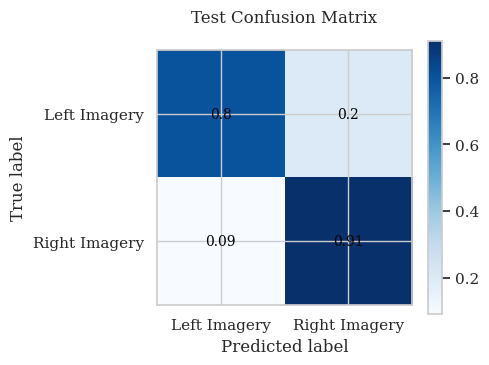

Full Data Size: ((1440, 3, 184, 126), (1440,))


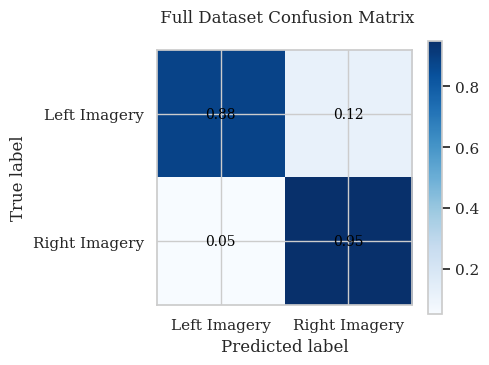

In [ ]:
# @title Training Pipeline
# for subject in subjects:
  # print(f"Training For Subject {subject}")
X, y, metadata = paradigm.get_data(dataset=dataset, subjects=pre_train_subjects)
# time.sleep(0.25)
# clear_output()
left_imagery_idx = np.where(y=='left_hand')[0]
right_imagery_idx = np.where(y=='right_hand')[0]
left_imagery = X[left_imagery_idx][:, choi, :]
right_imagery = X[right_imagery_idx][:, choi, :]

X, y = None, None
print(f"Epochs Shape: {(left_imagery.shape, right_imagery.shape)}")

assert left_imagery.shape == right_imagery.shape
N = left_imagery.shape[-1]
left_imagery.shape, right_imagery.shape

left_imagery = mne.filter.filter_data(left_imagery, fs, f1, f2)  # --> BandPass Filtering
right_imagery = mne.filter.filter_data(right_imagery, fs, f1, f2)
# time.sleep(0.25)
# clear_output()

left_imagery = left_imagery - left_imagery.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending
right_imagery = right_imagery - right_imagery.mean(axis=1, keepdims=True)
assert left_imagery.shape == right_imagery.shape
N = left_imagery.shape[-1]
left_imagery.shape, right_imagery.shape

# @title STFT Feature Computation
left_imagery_stft = []
right_imagery_stft = []

for epoch in tqdm(left_imagery, total=left_imagery.shape[0], desc="Generating Left Imagery STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  left_imagery_stft.append(epoch_stft)
left_imagery_stft = np.array(left_imagery_stft)

for epoch in tqdm(right_imagery, total=right_imagery.shape[0], desc="Generating Right Imagery STFTs"):
  epoch_stft = SFT.spectrogram(epoch, axis=-1)
  epoch_stft = epoch_stft[:, freqs, :]
  right_imagery_stft.append(epoch_stft)
right_imagery_stft = np.array(right_imagery_stft)
print(f"STFT Epochs Shape: {(left_imagery_stft.shape, right_imagery_stft.shape)}")

# @title Make Dataset
temp_y = [0]*left_imagery_stft.shape[0] + [1]*right_imagery_stft.shape[0]
temp_y = np.array(temp_y)
temp_X = np.vstack((
    left_imagery_stft,
    right_imagery_stft,
))

test_accuracies = []
test_f1s = []
test_sensitivities = []
for fold, (train_idx, test_idx) in enumerate(skf.split(temp_X, temp_y)):
  X_train, X_test = temp_X[train_idx], temp_X[test_idx]
  y_train, y_test = temp_y[train_idx], temp_y[test_idx]

  train = elbowMIDataset(X_train, torch.tensor(y_train).long(), transform=None)
  test = elbowMIDataset(X_test, torch.tensor(y_test).long())

  g = torch.Generator()
  g.manual_seed(42)
  train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, generator=g)
  test_loader = DataLoader(test, batch_size=test_batch, shuffle=False, generator=g)

  # @title Train
  model.to(device)
  for i in tqdm(range(n_iter), desc=f"Training Fold {fold+1}/{k}", total=n_iter):

    model.train()
    train_loss = 0
    train_acc = 0
    train_precision = 0
    for j, (x, y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)
      # print(f"Train: {torch.unique(y)}")
      optimizer.zero_grad()
      logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)

      l2_penalty = sum((p**2).sum() for p in model.parameters())
      loss = loss + l2_lambda*l2_penalty

      loss.backward()
      # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
      optimizer.step()

      # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
      pred = torch.softmax(logits, dim=-1)
      pred = torch.argmax(pred, dim=-1).cpu().detach().numpy()
      y = y.cpu().detach().numpy()
      y_bin = label_binarize(y, classes=range(2))
      if np.isnan(pred).sum() >0:
        print(logits)
      train_precision += average_precision_score(y_bin, pred, average="micro")
      train_loss += loss.item()
      train_acc += acc.item()

    train_precision /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

  # model.load_state_dict(chkpt.best_state)
  model.eval()
  all_preds = []
  all_labels = []
  best_F1 = 0
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
      probs = F.softmax(logits, dim=1)
      preds = torch.argmax(probs, dim=1)

      all_labels.append(y.cpu())
      all_preds.append(preds.cpu())

  all_labels = torch.cat(all_labels)
  all_preds = torch.cat(all_preds)
  fold_F1 = f1_score(all_labels, all_preds)

  if fold_F1 > best_F1:
    torch.save(model.state_dict(), "pretrained_model.pt")

    test_cm = confusion_matrix(all_labels, all_preds)
    test_cm = test_cm.astype(int)
    test_cm = test_cm / test_cm.sum(axis=1, keepdims=True)  # normalize by row
    test_cm = np.round(test_cm, 2)

    accuracy = acc_score(all_labels, all_preds)
    F1 = f1_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds)

# @title Evaluation
classes = ["Left Imagery", "Right Imagery"]
accuracy = np.round(accuracy, 2)
F1 = np.round(F1, 2)
sensitivity = np.round(sensitivity, 2)
print("------------Mean Performance---------------")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {F1}")
print(f"Recall: {sensitivity}")

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(test_cm, cmap="Blues")
# Add labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Annotate each cell
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, f"{test_cm[i, j]}",
                ha="center", va="center",
                color="black", fontsize=10)
# Axis labels & title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Test Confusion Matrix", pad=20)
# ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

fig.colorbar(im)
plt.tight_layout()
plt.savefig(f"test_confusion_matrix.png", bbox_inches="tight", dpi=300)
plt.show()

## @title Train Confusion Matrix

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
print(f"Full Data Size: {(X.shape, y.shape)}")
train_test = elbowMIDataset(X, torch.tensor(y).long(), transform=None)
_loader = DataLoader(train_test, batch_size=train_batch+test_batch, shuffle=False, generator=g)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
  for x, y in _loader:
    x = x.to(device)
    y = y.to(device)
    out = model(x)
    probs = F.softmax(out, dim=1)
    preds = torch.argmax(probs, dim=1)
    all_preds.append(preds.cpu())
    all_labels.append(y.cpu())
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
# X, y = 0, 0

cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype(int)
cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
cm = np.round(cm, 2)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
# Add labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="black", fontsize=10)
# Axis labels & title
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f" Full Dataset Confusion Matrix", pad=20)
# ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

fig.colorbar(im)
plt.tight_layout()
plt.savefig(f"full_data_confusion_matrix.png", bbox_inches="tight", dpi=300)
plt.show()
# time.sleep(2)
# clear_output()

In [ ]:
_d_model, _d_ff, _num_heads, _n_layers, _d_in, _n_tokens

(512, 1024, 8, 2, 63, 14)

In [ ]:
W, hop_, nfft

(1024, 16, 1536)

In [ ]:
# ! rm -rf experiments/Exp_2.2:run_3

In [ ]:
# @title Save Experiment Parameters & Artifacts

import shutil

exp_name = "Exp_2.2:run_5"
exp_data = {
    "base_experiment": "Exp_2.2:run_1",
    "dataset": "BCI Competition IV Dataset-2b",
    "channels": {"method": "Selection", "names":["C3", "C4", "Cz"]},
    "feature-engineering": {
        "BandPass-Filter": {"low":float(f1), "high":float(f2)},
        "Epoch_Processing": "Time-points Detrending (Across Channels)",
        "STFT": {"W":W, "window_type": "cosine", "HOP":hop_, "fs": fs, "NFFT":nfft, "method":"scipy.ShorTimeFFT.spectrogram"},
        "Spectrogram_Scaling": None,
    },
    "augmentation": None,
    "model": {"name":"SPEC_CNN_T1", "parameters":{
        "d_in":_d_in, "d_model":_d_model, "n_tokens":_n_tokens,
        "num_heads":_num_heads, "d_ff":_d_ff,
        "n_layers":_n_layers, "dropout":_dropout
    }},
    "optimizer": {
        "method":"Adam", "lr": 3E-4,
        "betas": [0.9, 0.99], "weight_decay":1E-4},
    "lr_scheduler": None,
    "regularization": {
        "weight_decay": 1E-4,
        "L2": l2_lambda,
        "EntropyLabelSmooth": LBL_SMOOTH,
    },
    "loss": "CrossEntropyLoss",
    "labels": ["Left Imagery", "Right Imagery"],
    "metric": {
        "Accuracy": float(accuracy),
        "F1": float(F1),
        "Sensitivity": float(sensitivity),
    },
    "N_Kfolds": k,
}

if ~os.path.exists(f"experiments/{exp_name}"):
  os.makedirs(f"experiments/{exp_name}")

if ~os.path.exists(f"experiments/{exp_name}/run.yaml"):
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    f.write(yaml.dump(exp_data))
    f.close()
else:
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    existing_data = yaml.load(f)
    existing_data.update(exp_data)
    f.write(yaml.dump(existing_data))
    f.close()

# validation_df.to_csv(f"experiments/{exp_name}/subjects_validation_df.csv", index=False)

for subject in subjects:
  shutil.copy(f"confusion_matrix.png", f"experiments/{exp_name}/")
  # shutil.copy(f"subject_{subject}_test_set_confusion_matrix.png", f"experiments/{exp_name}/")

torch.save(model.state_dict(), f"experiments/{exp_name}/model_state_dict.pt")
print(f"Model-weights Saved at: experiments/{exp_name}")
print(f"Experiment saved at: experiments/{exp_name}")

Model-weights Saved at: experiments/Exp_2.2:run_5
Experiment saved at: experiments/Exp_2.2:run_5


In [ ]:
# @title Download Artifacts

!zip -r experiments.zip experiments/

from google.colab import files
files.download("experiments.zip")

  adding: experiments/ (stored 0%)
  adding: experiments/Exp_2.2:run_4/ (stored 0%)
  adding: experiments/Exp_2.2:run_4/model_state_dict.pt (deflated 9%)
  adding: experiments/Exp_2.2:run_4/confusion_matrix.png (deflated 15%)
  adding: experiments/Exp_2.2:run_4/run.yaml (deflated 41%)
  adding: experiments/Exp_2.2:run_3/ (stored 0%)
  adding: experiments/Exp_2.2:run_3/model_state_dict.pt (deflated 8%)
  adding: experiments/Exp_2.2:run_3/confusion_matrix.png (deflated 16%)
  adding: experiments/Exp_2.2:run_3/run.yaml (deflated 41%)
  adding: experiments/Exp_2.2:run_1/ (stored 0%)
  adding: experiments/Exp_2.2:run_1/model_state_dict.pt (deflated 9%)
  adding: experiments/Exp_2.2:run_1/confusion_matrix.png (deflated 15%)
  adding: experiments/Exp_2.2:run_1/run.yaml (deflated 41%)
  adding: experiments/Exp_2.2:run_5/ (stored 0%)
  adding: experiments/Exp_2.2:run_5/model_state_dict.pt (deflated 9%)
  adding: experiments/Exp_2.2:run_5/confusion_matrix.png (deflated 16%)
  adding: experiments

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 10-Fold Per Subject Fine-Tuning



In [ ]:
model

SPEC_CNN_T1(
  (backbone): BACKBONE_CNN(
    (in_btn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv11): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu11): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn11): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv21): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu21): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn21): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool21): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv31): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (relu31): LeakyReLU(negative_slope=0.01, inplace=True)
    (btn31): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool31): AvgPool2d(kernel_size=(2, 2)

In [ ]:
# @title Functions

import torch
import torch.nn.functional as F

def supervised_contrastive_loss(features, labels, temperature=0.1):
  """
  features: [B, E] - your embeddings
  labels: [B] or [B, 1] - binary labels (0/1)
  """
  device = features.device
  batch_size = features.shape[0]

  # Normalize features
  features = F.normalize(features, dim=1)

  # Compute similarity matrix
  similarity_matrix = torch.matmul(features, features.T) / temperature

  # Create mask for positive pairs (same class)
  labels = labels.view(-1, 1)
  mask = torch.eq(labels, labels.T).float().to(device)

  # Remove self-similarity
  mask = mask - torch.eye(batch_size).to(device)

  # Compute exp of similarities
  exp_sim = torch.exp(similarity_matrix)

  # Sum of exp similarities for normalization
  sum_exp_sim = exp_sim.sum(dim=1, keepdim=True) - torch.diag(exp_sim).unsqueeze(1)

  # Positive pairs
  pos_sim = exp_sim * mask

  # Contrastive loss
  loss = -torch.log((pos_sim.sum(dim=1) + 1e-8) / (sum_exp_sim + 1e-8))

  return loss.mean()

#### Fine-Tuning

In [ ]:
model = SPEC_CNN_T1(d_in=_d_in, d_model=_d_model, num_heads=_num_heads,
                    n_layers=_n_layers, n_tokens=_n_tokens, d_ff=_d_ff,
                    dropout=0.3)

optimizer = torch.optim.Adam([
    {"params": list(model.backbone.conv21.parameters()) +
               list(model.backbone.relu21.parameters()) +
               list(model.backbone.avgpool21.parameters()), "lr": lr_/10},
    {"params": list(model.backbone.conv31.parameters()) +
               list(model.backbone.relu31.parameters()) +
               list(model.backbone.avgpool31.parameters()), "lr": lr_/10},
    {"params": list(model.embedding.parameters()) +
               list(model.embedding_relu.parameters()), "lr": lr_/10},
    {"params": model.enc1.parameters(), "lr": lr_/2},
    {"params": model.fc.parameters(), "lr": lr_},
])

weights = torch.load("pretrained_model.pt")
model.load_state_dict(weights)

# model.fc = nn.Sequential(
#     nn.Linear(_d_model, _d_model*3),
#     nn.LeakyReLU(),
#     nn.Linear(_d_model*3, 2)
# )

for param in model.backbone.parameters():
  param.requires_grad = False
for layer in [model.backbone.conv21, model.backbone.relu21, model.backbone.avgpool21]:
  for param in layer.parameters():
    param.requires_grad = True
for layer in [model.backbone.conv31, model.backbone.relu31, model.backbone.avgpool31]:
  for param in layer.parameters():
    param.requires_grad = True
for param in model.embedding.parameters():
  param.requires_grad = True
for param in model.enc1.parameters():
  param.requires_grad = True
for param in model.fc.parameters():
  param.requires_grad = True

augment = Compose([
    Masking(channel_dropout_prob=0.1, time_mask_width=10, freq_mask_width=12),
    TimeShifting(max_shift_ratio=0.08),
    NoiseAugmentation(noise_types=['gaussian'], gaussian_std_range=(0.005, 0.02))
])

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Create early stopping and checkpointing instances
early_stopper = EarlyStopping(patience=5, min_delta=0.01)
model_saver = CheckpointModel(margin=0.0)

LAMBDA_CONTRAST = 0.5

In [ ]:
fine_tune_subjects

[9, 1, 6, 3]

In [ ]:
accuracies = {}
kappas = {}
F1s = {}
sensitivities = {}

In [ ]:
# @title Training Pipeline

for s, subject in enumerate(fine_tune_subjects):
  print(f"Training For Subject {subject}: {s+1}/{len(fine_tune_subjects)}")

  s_x, s_y, metadata = paradigm.get_data(dataset=dataset, subjects=[subject])
  # time.sleep(0.25)
  # clear_output()
  left_imagery_idx = np.where(s_y=='left_hand')[0]
  right_imagery_idx = np.where(s_y=='right_hand')[0]
  left_imagery = s_x[left_imagery_idx][:, choi, :]
  right_imagery = s_x[right_imagery_idx][:, choi, :]
  s_x, s_y = 0, 0
  X = np.vstack((left_imagery, right_imagery))
  y = np.hstack((np.zeros(left_imagery.shape[0]), np.ones(right_imagery.shape[0])))
  print(f"Training Epochs Shape: {(X_train.shape, y_train.shape)}")

  X = mne.filter.filter_data(X, fs, f1, f2)  # --> BandPass Filtering
  X = X - X.mean(axis=1, keepdims=True)  # --> Epochs Time-points (Across Channels) Detrending

  # @title STFT Feature Computation
  X_stft = []
  for epoch in tqdm(X, total=X.shape[0], desc="Generating Train set STFTs"):
    epoch_stft = SFT.spectrogram(epoch, axis=-1)
    epoch_stft = epoch_stft[:, freqs, :]
    X_stft.append(epoch_stft)
  X_stft = np.array(X_stft)
  print(f"STFT Epochs Shape: {(X_stft.shape, y.shape)}")

  # @title Make Dataset
  weights = torch.load("pretrained_model.pt")
  model.load_state_dict(weights)
  model.to(device)
  model.train()

  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
  for train_idx, test_idx in sss.split(X_stft, y):
    X_train_stft, X_val_stft = X_stft[train_idx], X_stft[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
  val = elbowMIDataset(X_val_stft, torch.tensor(y_val).long())
  val_loader = DataLoader(val, batch_size=test_batch, shuffle=False, generator=g)

  for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_stft, y_train)):
  # sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    x1, x2 = X_train_stft[train_idx], X_train_stft[test_idx]
    y1, y2 = y_train[train_idx], y_train[test_idx]

    x1 = np.vstack((x1, X_test))
    y1 = np.hstack((y1, y_test))
    # print(f"Train Fold Shape: {(x1.shape, y1.shape)}")
    train = elbowMIDataset(x1, torch.tensor(y1).long(), transform=None, augment_prob=0.0)
    test = elbowMIDataset(x2, torch.tensor(y2).long())

    g = torch.Generator()
    g.manual_seed(42)
    train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, generator=g)
    test_loader = DataLoader(test, batch_size=test_batch, shuffle=False, generator=g)

    # @title Train
    for i in tqdm(range(n_iter), desc=f"Training Fold {fold+1}/{k}", total=n_iter):

      model.train()
      train_loss = 0
      train_acc = 0
      train_precision = 0
      for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        # print(f"Train: {torch.unique(y)}")
        optimizer.zero_grad()
        # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
        logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
        l2_penalty = sum((p**2).sum() for p in model.parameters())
        # cnt_loss = LAMBDA_CONTRAST*supervised_contrastive_loss(logits, y)
        # loss = loss + cnt_loss + l2_lambda*l2_penalty
        loss = loss + l2_lambda*l2_penalty

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(mi_cnn.parameters(), 1)
        optimizer.step()

        # pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
        pred = torch.softmax(logits, dim=-1)
        pred = torch.argmax(pred, dim=-1).cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        y_bin = label_binarize(y, classes=range(2))
        if np.isnan(pred).sum() >0:
          print(logits)
        train_precision += average_precision_score(y_bin, pred, average="micro")
        train_loss += loss.item()
        train_acc += acc.item()

      train_precision /= len(train_loader)
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)

    # model.load_state_dict(model_saver.best_state)
    model.eval()
    all_labels = []
    all_preds = []
    # best_F1 = 0
    best_acc = 0
    for j, (x, y) in enumerate(val_loader):
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        # logits, loss, acc = fine_tune_run(encoder, model, clf_head, x, y, LBL_SMOOTH=LBL_SMOOTH)
        logits, loss, acc = run(model, x, y, LBL_SMOOTH=LBL_SMOOTH)
        pred = torch.softmax(logits, dim=-1)
        pred = torch.argmax(pred, dim=-1).cpu()
        y = y.cpu()

        all_labels.append(y)
        all_preds.append(pred)

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    # fold_F1 = f1_score(all_labels, all_preds)
    fold_acc = acc_score(all_labels, all_preds)

    if fold_acc > best_acc:
      accuracy = acc_score(all_labels, all_preds)
      kappa = ((accuracy-0.5)/(1-0.5))
      F1 = f1_score(all_labels, all_preds)
      sensitivity = recall_score(all_labels, all_preds)

  # @title Evaluation
  # train_test = elbowMIDataset(X_val_stft, torch.tensor(y_val).long(), transform=None)
  # _loader = DataLoader(train_test, batch_size=3, shuffle=False, generator=g)

  # all_preds = []
  # all_labels = []

  # model.eval()
  # with torch.no_grad():
  #   for x, y in _loader:
  #     x = x.to(device)
  #     y = y.to(device)
  #     out = model(x)
  #     probs = F.softmax(out, dim=1)
  #     preds = torch.argmax(probs, dim=1)
  #     all_preds.append(preds.cpu())
  #     all_labels.append(y.cpu())
  # all_preds = torch.cat(all_preds)
  # all_labels = torch.cat(all_labels)
  # X, y = 0, 0

  # cm = confusion_matrix(all_labels, all_preds)
  # cm = cm.astype(int)
  # cm = cm / cm.sum(axis=1, keepdims=True)  # normalize by row
  # cm = np.round(cm, 2)

  # classes = ["Left Imagery", "Right Imagery"]

  # fig, ax = plt.subplots(figsize=(5, 4))
  # im = ax.imshow(cm, cmap="Blues")

  # # Add labels
  # ax.set_xticks(np.arange(len(classes)))
  # ax.set_yticks(np.arange(len(classes)))
  # ax.set_xticklabels(classes)
  # ax.set_yticklabels(classes)

  # # Annotate each cell
  # for i in range(cm.shape[0]):
  #     for j in range(cm.shape[1]):
  #         ax.text(j, i, f"{cm[i, j]}",
  #                 ha="center", va="center",
  #                 color="black", fontsize=10)

  # # Axis labels & title
  # ax.set_xlabel("Predicted label")
  # ax.set_ylabel("True label")
  # ax.set_title(f"Confusion Matrix", pad=20)
  # # ax.set_title("Train Set Confusion Matrix \n (Augmented Samples Inlcuded)")

  # fig.colorbar(im)
  # plt.tight_layout()
  # plt.savefig(f"confusion_matrix.png", bbox_inches="tight", dpi=300)
  # plt.show()

  # @title Subject Validation
  # acc = acc_score(all_labels, all_preds)
  # kappa = (acc - 0.5) / ( 1 - 0.5)
  # F1 = f1_score(all_labels, all_preds, average='macro')
  # sensitivity = recall_score(all_labels, all_preds, average='macro')

  accuracies[subject] = np.round(accuracy, 2)
  kappas[subject] = np.round(kappa, 2)
  F1s[subject] = np.round(F1, 2)
  sensitivities[subject] = np.round(sensitivity, 2)

  print(" ")
  print(f"Subject Accuracy: {round(accuracies[subject], 2)}")
  print(f"subject Kappa: {round(kappas[subject], 2)}")
  print(f"Subject F1-Score: {round(F1s[subject], 2)}")
  print(f"subject Sensitivity: {round(sensitivities[subject], 2)}")

  time.sleep(5)
  clear_output()

In [ ]:
x1.shape, x2.shape, X_val_stft.shape

((469, 3, 184, 126), (20, 3, 184, 126), (87, 3, 184, 126))

In [ ]:
# compute mean and std for accuracy and kappa
accuracies["Mean"] = np.round(np.mean(list(accuracies.values())), 2)
accuracies["Std"]  = np.round(np.std(list(accuracies.values())), 2)

kappas["Mean"] = np.round(np.mean(list(kappas.values())), 2)
kappas["Std"]  = np.round(np.std(list(kappas.values())), 2)

# compute mean and std for accuracy and kappa
F1s["Mean"] = np.round(np.mean(list(F1s.values())), 2)
F1s["Std"]  = np.round(np.std(list(F1s.values())), 2)

# compute mean and std for accuracy and kappa
sensitivities["Mean"] = np.round(np.mean(list(sensitivities.values())), 2)
sensitivities["Std"]  = np.round(np.std(list(sensitivities.values())), 2)

In [ ]:
# accuracies.pop("Mean")
# accuracies.pop("Std")

# kappas.pop("Mean")
# kappas.pop("Std")

# F1s.pop("Mean")
# F1s.pop("Std")

# sensitivities.pop("Mean")
# sensitivities.pop("Std")

In [ ]:
# @title 70% Evaluation: backbone(conv21, conv31).lr_ = lr_/10embedding.lr_ = lr_/10, enc1.lr_ = lr_/2, fc.lr_ = lr_

# build DataFrame with subjects included
validation_df = pd.DataFrame({
    "Accuracy": pd.Series(accuracies),
    "Kappa": pd.Series(kappas),
    "F1-Score": pd.Series(F1s),
    "Sensitivity": pd.Series(sensitivities)
})

validation_df

,Accuracy,Kappa,F1-Score,Sensitivity
9,0.74,0.49,0.78,0.92
1,0.65,0.31,0.63,0.58
6,0.60,0.20,0.65,0.74
3,0.73,0.46,0.69,0.60
Mean,0.68,0.36,0.69,0.71
Std,0.05,0.10,0.05,0.12


In [ ]:
# @title 10% Evaluation: backbone(conv21, conv31).lr_ = lr_/10embedding.lr_ = lr_/10, enc1.lr_ = lr_/2, fc.lr_ = lr_

# build DataFrame with subjects included
validation_df = pd.DataFrame({
    "Accuracy": pd.Series(accuracies),
    "Kappa": pd.Series(kappas),
    "F1-Score": pd.Series(F1s),
    "Sensitivity": pd.Series(sensitivities)
})

validation_df

,Accuracy,Kappa,F1-Score,Sensitivity
9,0.97,0.93,0.97,1.00
1,0.66,0.31,0.58,0.50
6,0.69,0.38,0.73,0.86
3,0.93,0.86,0.93,0.93
Mean,0.81,0.62,0.80,0.82
Std,0.12,0.25,0.14,0.17


In [ ]:
# @title Stratified Shuffle&Split

# build DataFrame with subjects included
# validation_df = pd.DataFrame({
#     "Accuracy": pd.Series(accuracies),
#     "Kappa": pd.Series(kappas),
#     "F1-Score": pd.Series(F1s),
#     "Sensitivity": pd.Series(sensitivities)
# })

# validation_df

In [ ]:
# @title Stratified K-Fold

# build DataFrame with subjects included
# validation_df = pd.DataFrame({
#     "Accuracy": pd.Series(accuracies),
#     "Kappa": pd.Series(kappas),
#     "F1-Score": pd.Series(F1s),
#     "Sensitivity": pd.Series(sensitivities)
# })

# validation_df

In [ ]:
# @title Save Experiment Parameters & Artifacts

import shutil

exp_name = "Exp_2.2:run_5"
exp_data = {
    "base_experiment": "Exp_2.2:run_1",
    "dataset": "BCI Competition IV Dataset-2b",
    "channels": {"method": "Selection", "names":["C3", "C4", "Cz"]},
    "feature-engineering": {
        "BandPass-Filter": {"low":float(f1), "high":float(f2)},
        "Epoch_Processing": "Time-points Detrending (Across Channels)",
        "STFT": {"W":W, "window_type": "cosine", "HOP":hop_, "fs": fs, "NFFT":nfft, "method":"scipy.ShorTimeFFT.spectrogram"},
        "Spectrogram_Scaling": None,
    },
    "augmentation": None,
    "model": {"name":"SPEC_CNN_T1", "parameters":{
        "d_in":_d_in, "d_model":_d_model, "n_tokens":_n_tokens,
        "num_heads":_num_heads, "d_ff":_d_ff,
        "n_layers":_n_layers, "dropout":_dropout
    }},
    "optimizer": {
        "method":"Adam", "lr": 3E-4,
        "betas": [0.9, 0.99], "weight_decay":1E-4},
    "lr_scheduler": None,
    "regularization": {
        "weight_decay": 1E-4,
        "L2": l2_lambda,
        "EntropyLabelSmooth": LBL_SMOOTH,
    },
    "loss": "CrossEntropyLoss",
    "labels": ["Left Imagery", "Right Imagery"],
    "metric": {
        "Accuracy": float(accuracy),
        "F1": float(F1),
        "Sensitivity": float(sensitivity),
    },
    "N_Kfolds": k,
}

if ~os.path.exists(f"experiments/{exp_name}"):
  os.makedirs(f"experiments/{exp_name}")

if ~os.path.exists(f"experiments/{exp_name}/run.yaml"):
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    f.write(yaml.dump(exp_data))
    f.close()
else:
  with open(f"experiments/{exp_name}/run.yaml", "w") as f:
    existing_data = yaml.load(f)
    existing_data.update(exp_data)
    f.write(yaml.dump(existing_data))
    f.close()

# validation_df.to_csv(f"experiments/{exp_name}/subjects_validation_df.csv", index=False)

for subject in subjects:
  shutil.copy(f"confusion_matrix.png", f"experiments/{exp_name}/")
  # shutil.copy(f"subject_{subject}_test_set_confusion_matrix.png", f"experiments/{exp_name}/")

torch.save(model.state_dict(), f"experiments/{exp_name}/model_state_dict.pt")
print(f"Model-weights Saved at: experiments/{exp_name}")
print(f"Experiment saved at: experiments/{exp_name}")

# Semantic Representation Learning

### Contrastive Alignment

In [ ]:
# @title Encoder

def nt_xent_loss(logits, labels, temperature=0.5):
  eps = 1E-8

  labels = labels.view(-1, 1)
  target = torch.eq(labels, labels.T).to(torch.float32).to(device)
  target.fill_diagonal_(0)

  B = logits.size(0)
  # logits = logits.reshape(B, -1)
  logits = F.normalize(logits, dim=1)
  sim = (logits @ logits.T)
  sim[torch.eye(B).bool()] = 0

  loss = F.binary_cross_entropy_with_logits(sim/temperature, target, reduction="mean")
  return loss

class SPEC_Encoder(nn.Module):
  def __init__(self, n_freqs=45, n_times=26, n_channels=6, n_classes=6, NGV_SLOPE=0.1, temperature=2):
    super(SPEC_Encoder, self).__init__()
    self.height = n_freqs
    self.width = n_times
    self.ch = n_channels
    self.n_classes = n_classes
    self.NGV_SLOPE = NGV_SLOPE
    self.temperature = temperature

    self.resnet = models.resnet18(pretrained=False)
    self.resnet.conv1 = nn.Conv2d(self.ch*3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    self.conv1 = nn.Conv3d(3, self.n_classes, (2, 8, 8), stride=(1, 4, 4), groups=1)
    self.pool1 = nn.AdaptiveMaxPool3d((5, 40, 40))

    self.conv2 = nn.Conv3d(self.n_classes, self.n_classes, (2, 4, 4), stride=(1, 2, 2), groups=self.n_classes)
    self.pool2 = nn.AdaptiveMaxPool3d((3, 16, 16))

    self.proj = nn.Linear(self.n_classes*3*16*16, 625)

  def forward(self, x, y=None, probe=False):
    B, _, _, _, _ = x.size()
    x = rearrange(x, 'b e h w c -> b c e h w')
    x = x/255
    # x = x.unsqueeze(1)
    # x = self.resnet(x)

    x = F.dropout(x, 0.2)
    x = self.conv1(x)
    x = self.pool1(x)
    x = F.elu(x)

    x = self.conv2(x)
    x = self.pool2(x)
    x = F.elu(x)

    B, K, C, H, W = x.size()
    x = x.reshape(B, -1)
    x = self.proj(x)

    if probe==True:
      return x.reshape(B, -1)
    if y is not None:
      loss = nt_xent_loss(x, y, temperature=self.temperature)
      return x, loss
    return x

In [ ]:
# @title Train

from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
# from torchmetrics.classification import MulticlassAveragePrecision
# mAP = MulticlassAveragePrecision(num_classes=6, average="macro")

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

mi_encoder = SPEC_Encoder(n_freqs=45, n_times=22, n_channels=6, n_classes=3, NGV_SLOPE=0.2, temperature=10).to(device)
# mi_encoder.apply(init_weights)

n_iter = 700
eval_inter = 10
n_evals = 6

history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_precision": [],
    "test_precision": [],
    "iter": [],
    "lr": []
}

lr_ = 1E-2
momentum_ = 0.9
betas_ = (0.9, 0.99)
# optimizer = torch.optim.SGD(mi_encoder.parameters(), lr=lr_, momentum=momentum_, weight_decay=0.0)
optimizer = torch.optim.Adam(mi_encoder.parameters(), lr=lr_, betas=betas_, weight_decay=0.0)
lr_scheduler = LRScheduler(lr_, patience=4, factor=0.3, margin=1E-4, n_evals=10)
moment_scheduler = LRScheduler(momentum_, patience=2, factor=0.3, margin=0.01, n_evals=10)

chkpt = CheckpointModel(0)

for i in tqdm(range(n_iter), desc="Training", total=n_iter):

  mi_encoder.train()
  train_loss = 0
  for j, (x, y) in enumerate(train_loader):
    if j>= n_evals:
      break
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = mi_encoder(x, y)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(mi_encoder.parameters(), 1)
    optimizer.step()

    pred = torch.softmax(logits, dim=-1).cpu().detach().numpy()
    # pred = torch.softmax(logits, dim=-1)
    # pred = torch.argmax(pred, dim=-1).cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    y_bin = label_binarize(y, classes=range(3))
    if np.isnan(pred).sum() >0:
      print(logits)
    train_loss += loss.item()
  train_loss /= n_evals

  if i==0 or i%eval_inter==0 or i==n_iter-1:
    mi_encoder.eval()
    test_loss = 0
    with torch.no_grad():
      for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits, loss = mi_encoder(x, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["iter"].append(i)
    history["lr"].append(lr_)

    print(f"TrainLoss={train_loss:.4f}, TestLoss={test_loss:.4f}, lr, moment=({lr_:.2E},{momentum_:.2E})")
    chkpt.checkpoint(test_loss, mi_encoder, "Checkpoint")

    lr_ = lr_scheduler.exponential_lr(test_loss)
    # momentum_ = moment_scheduler.exponential_lr(test_loss)
    for param_group in optimizer.param_groups:
      param_group["lr"] = lr_
    # for param_group in optimizer.param_groups:
    #     param_group['momentum'] = momentum_

Training:   0%|          | 1/700 [00:02<25:47,  2.21s/it]

TrainLoss=0.7070, TestLoss=0.7035, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   2%|▏         | 11/700 [00:21<24:43,  2.15s/it]

TrainLoss=0.6983, TestLoss=0.6979, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   3%|▎         | 21/700 [00:40<22:08,  1.96s/it]

TrainLoss=0.6943, TestLoss=0.6940, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   4%|▍         | 31/700 [01:00<24:13,  2.17s/it]

TrainLoss=0.6945, TestLoss=0.6946, lr, moment=(1.00E-02,9.00E-01)


Training:   6%|▌         | 41/700 [01:18<21:39,  1.97s/it]

TrainLoss=0.6940, TestLoss=0.6942, lr, moment=(1.00E-02,9.00E-01)


Training:   7%|▋         | 51/700 [01:38<22:31,  2.08s/it]

TrainLoss=0.6936, TestLoss=0.6938, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:   9%|▊         | 61/700 [01:59<23:36,  2.22s/it]

TrainLoss=0.6934, TestLoss=0.6937, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  10%|█         | 71/700 [02:18<22:15,  2.12s/it]

TrainLoss=0.6940, TestLoss=0.6937, lr, moment=(1.00E-02,9.00E-01)


Training:  12%|█▏        | 81/700 [02:38<21:35,  2.09s/it]

TrainLoss=0.6939, TestLoss=0.6936, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  13%|█▎        | 91/700 [03:00<23:29,  2.32s/it]

TrainLoss=0.6937, TestLoss=0.6936, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  14%|█▍        | 101/700 [03:18<19:32,  1.96s/it]

TrainLoss=0.6935, TestLoss=0.6940, lr, moment=(1.00E-02,9.00E-01)


Training:  16%|█▌        | 111/700 [03:38<20:47,  2.12s/it]

TrainLoss=0.6938, TestLoss=0.6938, lr, moment=(1.00E-02,9.00E-01)


Training:  17%|█▋        | 121/700 [03:57<19:19,  2.00s/it]

TrainLoss=0.6942, TestLoss=0.6934, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  19%|█▊        | 131/700 [04:17<19:51,  2.09s/it]

TrainLoss=0.6936, TestLoss=0.6934, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  20%|██        | 141/700 [04:36<18:50,  2.02s/it]

TrainLoss=0.6935, TestLoss=0.6934, lr, moment=(1.00E-02,9.00E-01)


Training:  22%|██▏       | 151/700 [04:55<19:26,  2.12s/it]

TrainLoss=0.6937, TestLoss=0.6938, lr, moment=(1.00E-02,9.00E-01)


Training:  23%|██▎       | 161/700 [05:16<20:06,  2.24s/it]

TrainLoss=0.6935, TestLoss=0.6931, lr, moment=(1.00E-02,9.00E-01)
Checkpoint


Training:  23%|██▎       | 164/700 [05:22<17:35,  1.97s/it]


KeyboardInterrupt: 

In [ ]:
min(history["train_loss"]), min(history["test_loss"])

(0.6757349868615469, 0.6932553052902222)

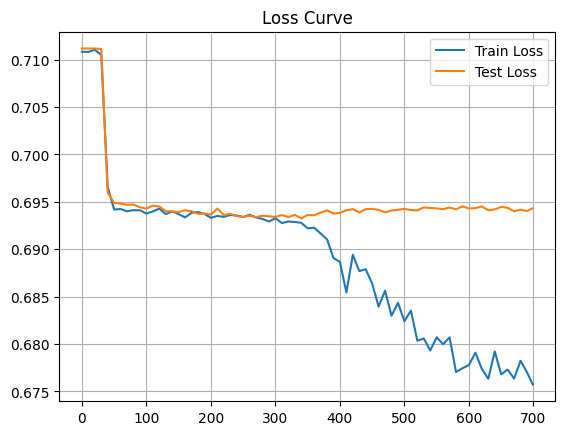

In [ ]:

plt.plot(history["iter"], history["train_loss"], label="Train Loss")
plt.plot(history["iter"], history["test_loss"], label="Test Loss")
plt.grid()
plt.title("Loss Curve")
plt.legend()

torch.Size([80, 1600]) torch.Size([80, 1600]) torch.Size([80, 1600])


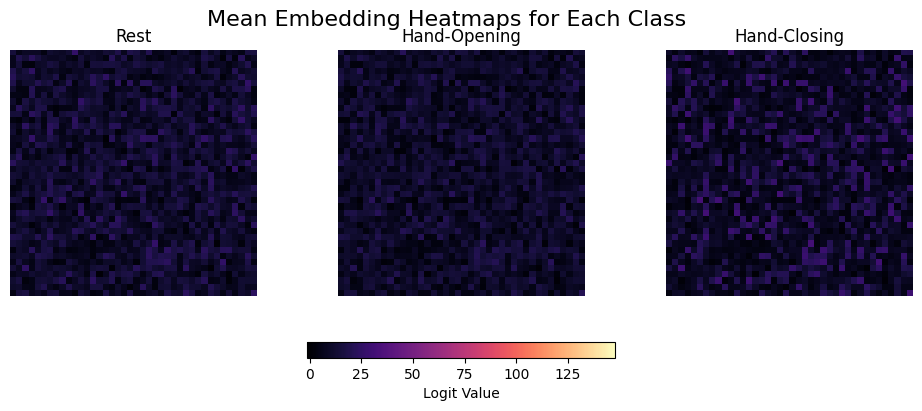

In [ ]:
x_0 = test.X[test.y == 0]
x_1 = test.X[test.y == 1]
x_2 = test.X[test.y == 2]

logits_0 = F.elu(mi_encoder(torch.tensor(x_0).to(device), probe=True))
logits_1 = F.elu(mi_encoder(torch.tensor(x_1).to(device), probe=True))
logits_2 = F.elu(mi_encoder(torch.tensor(x_2).to(device), probe=True))

print(logits_0.size(), logits_1.size(), logits_2.size())

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

vmin = min(logits_0.min(), logits_1.min(), logits_2.min()).cpu().item()
vmax = max(logits_0.max(), logits_1.max(), logits_2.max()).cpu().item()

images = []
for e, (embd, label) in enumerate(zip([logits_0, logits_1, logits_2], ["Rest", "Hand-Opening", "Hand-Closing"])):
    embd_ = embd.mean(axis=0).cpu().detach().numpy().reshape(40, 40)
    im = ax[e].imshow(embd_, cmap="magma", vmin=vmin, vmax=vmax)
    ax[e].set_title(label)
    ax[e].axis('off')
    images.append(im)

# Add a single colorbar at the top
cbar = fig.colorbar(images[0], ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
cbar.set_label("Logit Value")

fig.suptitle("Mean Embedding Heatmaps for Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.1])
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE


# Convert embeddings to numpy for analysis
emb_0 = logits_0.cpu().detach().numpy()
emb_1 = logits_1.cpu().detach().numpy()
emb_2 = logits_2.cpu().detach().numpy()

# 1. Calculate pairwise distances between class means
mean_0 = np.mean(emb_0, axis=0)
mean_1 = np.mean(emb_1, axis=0)
mean_2 = np.mean(emb_2, axis=0)

means = np.vstack([mean_0, mean_1, mean_2])
class_labels = ["Rest", "Hand-Opening", "Hand-Closing"]

dist_matrix = cdist(means, means)
print("\nDistance matrix between class means:")
for i, label_i in enumerate(class_labels):
    for j, label_j in enumerate(class_labels):
        if i < j:  # Only print upper triangle
            print(f"Distance between {label_i} and {label_j}: {dist_matrix[i, j]:.4f}")

# 2. Calculate within-class and between-class variance
all_embeddings = np.vstack([emb_0, emb_1, emb_2])
all_labels = np.hstack([np.zeros(len(emb_0)), np.ones(len(emb_1)), 2*np.ones(len(emb_2))])

# 3. Calculate silhouette score - measure of how well samples are clustered
if len(emb_0) > 1 and len(emb_1) > 1 and len(emb_2) > 1:
    silhouette = silhouette_score(all_embeddings, all_labels)
    print(f"\nSilhouette score: {silhouette:.4f}")
    print("  - Closer to 1 means better separated clusters")
    print("  - Closer to 0 means overlapping clusters")
    print("  - Negative values mean samples are assigned to wrong clusters")

# 4. Visualize with t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']
for i, label in enumerate(["Rest", "Hand-Opening", "Hand-Closing"]):
    idx = all_labels == i
    plt.scatter(
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        c=colors[i],
        marker=markers[i],
        label=label,
        alpha=0.7
    )
plt.title("t-SNE Visualization of Class Embeddings")
plt.legend()
plt.tight_layout()
plt.savefig("class_embeddings_tsne.png")
plt.close()


Distance matrix between class means:
Distance between Rest and Hand-Opening: 70.6364
Distance between Rest and Hand-Closing: 139.8769
Distance between Hand-Opening and Hand-Closing: 171.3706

Silhouette score: -0.0355
  - Closer to 1 means better separated clusters
  - Closer to 0 means overlapping clusters
  - Negative values mean samples are assigned to wrong clusters


In [ ]:
def compute_class_separability():
    # Overall mean
    global_mean = np.mean(all_embeddings, axis=0)

    # Class means
    means = [mean_0, mean_1, mean_2]

    # Between-class scatter
    between_scatter = np.zeros((means[0].shape[0], means[0].shape[0]))
    for i, mean in enumerate([mean_0, mean_1, mean_2]):
        n_samples = [len(emb_0), len(emb_1), len(emb_2)][i]
        mean_diff = mean - global_mean
        between_scatter += n_samples * np.outer(mean_diff, mean_diff)

    # Within-class scatter
    within_scatter = np.zeros_like(between_scatter)
    for i, emb in enumerate([emb_0, emb_1, emb_2]):
        for sample in emb:
            diff = sample - means[i]
            within_scatter += np.outer(diff, diff)

    # Ensure within_scatter is invertible
    within_scatter += np.eye(within_scatter.shape[0]) * 1e-6

    # Calculate separability ratio (trace-based criterion)
    try:
        inv_within = np.linalg.inv(within_scatter)
        separability = np.trace(np.matmul(inv_within, between_scatter))
        return separability
    except np.linalg.LinAlgError:
        return "Error: Within-class scatter matrix is not invertible"

separability = compute_class_separability()
print(f"\nClass separability measure: {separability}")
print("  - Higher values indicate better class separation")


Class separability measure: -458437.2261522801
  - Higher values indicate better class separation
